# QF623 Portfolio Management
## Industry Portfolio
#### Industry Daily data 1st retrieved on `22th Apr 2024`
#### source website: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
#### missing data marked as `-99.99` or `-999.`
#### All calculations based on `Value Weighted Return` but NOT `Equity Weighted Return`

#### strategy evaluating period from `2010-01-01` to `2020-01-01`
#### strategy testing period from `2020-01-01` to `2024-04-18`


In [1]:
## only run this when necessary
# !pip install pandas-datareader
# !pip install yfinance
# !pip install seaborn
# !pip install --upgrade pandas
# !pip install statsmodels
# !pip install ta


In [2]:
import numpy as np # for numerical computing
import pandas as pd # for tabular data manipulation
import matplotlib.pyplot as plt # for data graphics
import matplotlib.dates as mdates
import matplotlib as mpl

import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf
import pandas_datareader.data as web 
from pandas_datareader import data as pdr
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
from ta.trend import IchimokuIndicator
import yfinance as yf
(
    yf
    .pdr_override()
)
import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")
import os
from scipy.interpolate import interp1d
import seaborn as sns
import os

from scipy.stats import norm
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from IPython.display import display
from IPython.display import Image

## <a id = "top">Table of Content</a>
### [0. Preprocessing data](#p0)
* 5 Industry Portfolios - clean
* 10 Industry Portfolios - clean
* 12 Industry Portfolios - clean
* 17 Industry Portfolios - clean
* 30 Industry Portfolios - clean

* 38 Industry Portfolios - missing 76860
* 48 Industry Portfolios - missing 56262
* 49 Industry Portfolios - missing 67186

### [1. Strategy Evaluation](#p1)
- ##### [1.1 Strategy Weightage](#p11)
- ##### [1.2 Holding History](#p12)
- ##### [1.3 In-Sample Performance](#p13)
- ##### [1.4 Value-at-Risk (1d in percentage) ](#p14)
- ##### [1.5 Consolidated Metrics ](#p15)
- ##### [1.6 Out-of-Sample Performance ](#p16)


### [2. Strategy Tuning](#p2)
- ##### [2.1 Efficiency Frontier](#p21)
- ##### [2.2 Rolling Window](#p22)
- ##### [2.3 Diversity Effect](#p23)
- ##### [2.4 Shorting Effect](#p24)
- ##### [2.5 Risk Management](#p25)
- ##### [2.6 Model Decisions](#p26)


## <a id = "p0"> 0. </a> Preprocessing Data [back to table of contents](#top)
#### missing data marked as `-99.99` or `-999.`
#### clean data chop from `2007-01-01`
#### strategy evaluating period from `2010-01-01` to `2020-01-01`
#### strategy testing period from `2020-01-01` to `2024-02-29`


In [3]:
def Ind_read(file, skip=9, ind_col=0, keep_duplicate='first'):
    df =\
        pd.read_csv(file,
                    skiprows=skip,
                    index_col=ind_col)        
    df.index =\
        df.index.astype(str)
    
    df =\
        df\
        [~df.index.duplicated(keep=keep_duplicate)]\
        [:-3]
    df =\
        df.astype(float)
    df.index =\
        pd.to_datetime(df.index)
    print("Missing data Counts: ", (df < -99).sum().sum())
    print(df.shape)
    return df

In [4]:
Ind38 = Ind_read('38_Industry_Portfolios_Daily.csv')
Ind48 = Ind_read('48_Industry_Portfolios_Daily.csv')
Ind49 = Ind_read('49_Industry_Portfolios_Daily.csv')

Missing data Counts:  76860
(25690, 38)
Missing data Counts:  56262
(25690, 48)
Missing data Counts:  67186
(25690, 49)


In [5]:
Ind5 = Ind_read('5_Industry_Portfolios_Daily.csv')
Ind10 = Ind_read('10_Industry_Portfolios_Daily.csv')
Ind12 = Ind_read('12_Industry_Portfolios_Daily.csv')
Ind17 = Ind_read('17_Industry_Portfolios_Daily.csv')
Ind30 = Ind_read('30_Industry_Portfolios_Daily.csv')

Missing data Counts:  0
(25690, 5)
Missing data Counts:  0
(25690, 10)
Missing data Counts:  0
(25690, 12)
Missing data Counts:  0
(25690, 17)
Missing data Counts:  0
(25690, 30)


Only good data shall be used, say the 5 to 30 portfolios daily data is suitable

In [6]:
Ind10

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
1926-07-01,0.02,-0.28,-0.23,0.57,-0.21,-0.02,-0.01,0.97,0.61,0.20
1926-07-02,0.29,1.07,0.81,0.64,0.36,0.26,0.01,0.13,0.47,0.10
1926-07-06,0.24,0.72,0.22,0.17,0.47,0.17,-0.23,0.23,0.73,-0.18
1926-07-07,0.27,0.06,0.23,-0.04,-0.10,0.32,-0.59,0.33,0.17,0.16
1926-07-08,0.69,0.05,0.15,0.12,0.35,0.40,-0.36,0.91,-0.20,0.39
...,...,...,...,...,...,...,...,...,...,...
2024-02-23,0.28,-1.81,0.37,-0.53,-0.30,0.01,0.52,0.43,0.46,0.31
2024-02-26,-0.46,2.62,-0.06,0.42,-0.40,-0.59,0.20,-0.22,-1.67,-0.41
2024-02-27,-0.02,0.43,0.22,-0.46,0.28,0.73,0.21,0.29,1.72,0.28
2024-02-28,-0.03,0.97,0.20,-0.40,-0.58,0.00,0.12,-0.57,0.33,-0.03


In [7]:
Ind5.tail()

,Cnsmr,Manuf,HiTec,Hlth,Other
2024-02-23,0.18,0.16,-0.29,0.43,0.31
2024-02-26,0.35,-0.23,-0.41,-0.22,-0.41
2024-02-27,0.19,0.32,0.31,0.29,0.28
2024-02-28,0.20,0.07,-0.55,-0.57,-0.03
2024-02-29,0.56,0.40,1.02,-0.90,0.42


In [8]:
Ind17.tail()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
2024-02-23,0.24,0.10,-0.55,0.54,0.69,0.42,0.49,0.79,1.35,0.45,-0.23,-1.46,0.26,0.46,0.39,0.20,-0.05
2024-02-26,-0.41,-0.81,0.38,-0.26,-0.46,-0.57,-0.33,-0.07,0.86,-0.13,0.48,2.46,-0.43,-1.67,0.21,-0.21,-0.68
2024-02-27,-0.11,0.63,-0.47,0.55,0.44,0.23,-0.15,0.97,1.17,0.28,-0.06,0.81,0.10,1.72,-0.12,0.26,0.49
2024-02-28,-0.08,-1.55,-0.32,-0.39,-0.11,-0.20,-0.18,0.48,-0.57,1.92,-0.58,1.04,-0.01,0.33,-0.02,-0.09,-0.38
2024-02-29,0.63,1.91,0.42,0.19,0.24,1.27,-0.68,1.05,0.82,0.54,1.67,0.05,0.45,0.33,0.74,0.21,0.45


In [9]:
Ind30.tail()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2024-02-23,0.07,0.64,0.45,0.03,-0.09,0.36,0.54,0.43,0.49,0.54,...,0.01,-0.04,-0.53,0.47,0.19,1.10,0.42,0.50,0.20,0.52
2024-02-26,-0.38,-0.64,-1.16,-0.40,-0.08,-0.54,-0.26,-0.22,-0.50,-0.28,...,-0.59,-0.74,0.05,-0.71,-0.57,0.52,0.19,-0.40,-0.21,-1.20
2024-02-27,-0.25,0.11,-0.02,1.75,0.60,0.05,0.49,0.29,0.41,2.19,...,0.73,0.33,0.19,0.47,0.10,0.22,0.34,-0.25,0.26,-0.08
2024-02-28,0.12,-0.50,0.27,-0.18,-0.46,0.41,-0.41,-0.57,-0.04,0.28,...,0.00,-0.45,-0.67,-0.13,-0.43,0.22,0.08,0.30,-0.09,0.70
2024-02-29,0.87,0.09,-0.39,1.36,1.57,-0.36,0.12,-0.90,1.11,1.83,...,0.56,1.01,1.07,1.05,0.93,0.09,0.79,0.50,0.21,-0.26


In [10]:
Ind30.loc['20240226':'20240229']

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2024-02-26,-0.38,-0.64,-1.16,-0.40,-0.08,-0.54,-0.26,-0.22,-0.50,-0.28,...,-0.59,-0.74,0.05,-0.71,-0.57,0.52,0.19,-0.40,-0.21,-1.20
2024-02-27,-0.25,0.11,-0.02,1.75,0.60,0.05,0.49,0.29,0.41,2.19,...,0.73,0.33,0.19,0.47,0.10,0.22,0.34,-0.25,0.26,-0.08
2024-02-28,0.12,-0.50,0.27,-0.18,-0.46,0.41,-0.41,-0.57,-0.04,0.28,...,0.00,-0.45,-0.67,-0.13,-0.43,0.22,0.08,0.30,-0.09,0.70
2024-02-29,0.87,0.09,-0.39,1.36,1.57,-0.36,0.12,-0.90,1.11,1.83,...,0.56,1.01,1.07,1.05,0.93,0.09,0.79,0.50,0.21,-0.26


## <a id = "p1"> 1. </a> Strategy Evaluating [back to table of contents](#top)

In [11]:
train_start = '20100101'
train_end = '20200101'
final_test = '20240301'

##### <a id = "p11"> </a> 1.1 Strategy Weightage [back to table of contents](#top)

In [12]:
def Eff_Front(Ind_daily, start, end, bounds = Bounds(0,1)):
    
    '''
    Using `minimize` function for solution solving

    * function: calculate annualized risk from normal daily return
    * initial guess: equal weight (or other guess vector)
    * method: `trust-constr`
    * linear_constraint
    * bounds

    -> solve for result

    '''
    Ind_ret =\
        Ind_daily.loc[start:end]
    if end in Ind_ret:
        Ind_ret = Ind_ret[:-1]
    # convert the percentage value back to decimal
    Ind_ret = Ind_ret / 100
    
    r = np.mean(Ind_ret,axis=0)*252     
    cov = Ind_ret.cov()
    port_stderr = lambda w:np.sqrt(np.dot(w,np.dot(w,cov))*252)
    invSharpe = lambda w:np.sqrt(np.dot(w,np.dot(w,cov))*252)/(r@w)    
    w = np.ones(Ind_ret.shape[1])
    x0 = w/np.sum(w) 
    
    linear_constraint =\
        LinearConstraint(np.ones((Ind_ret.shape[1],),dtype=int),1,1)    
    
#     bounds = Bounds(0,1)    
    
    result_min =\
        minimize(port_stderr,
                 x0,
                 method="trust-constr",
                 constraints=linear_constraint,
                 bounds=bounds)    
    w_min = result_min.x

    Return_min = r@w_min
    Risk_min = port_stderr(w_min)
    
    result_max =\
        minimize(invSharpe,
                 x0,
                 method="trust-constr",
                 constraints=linear_constraint,
                 bounds=bounds)  
    
    w_max = result_max.x 
    Return_max = r@w_max
    Risk_max = port_stderr(w_max)    
    
    return [w_min, Return_min, Risk_min],[w_max, Return_max, Risk_max]

In [13]:
Eff10_min, Eff10_max =\
   Eff_Front(Ind10, train_start, train_end, Bounds(0,1)) 

print("weightage by min risk portfolio is: ", Eff10_min[0])
print("Sum of total weightages: ", Eff10_min[0].sum())
print("expected annualize min risk portfolio return is: ", Eff10_min[1])
print("expected annualize min risk portfolio volatility is: ", Eff10_min[2])

weightage by min risk portfolio is:  [5.02979449e-01 2.33450411e-06 3.96142219e-06 3.03047645e-06
 1.16618021e-07 1.90358890e-02 9.17833499e-02 6.06983957e-02
 3.25490389e-01 3.08402893e-06]
Sum of total weightages:  0.9999999999999951
expected annualize min risk portfolio return is:  0.1251955656790943
expected annualize min risk portfolio volatility is:  0.11799572304964427


##### <a id = "p12"> </a> 1.2 Holding History [back to table of contents](#top)

In [14]:
def w_construct(idx, cols, w_list):
    w_df =\
        pd.DataFrame(index = idx,
                     columns = cols)
    w_df.iloc[:] = w_list
    w_df['Sum_w'] = w_df.sum(axis=1)
    return w_df

In [15]:
# construct holding weight indexed by date tags
idx =\
    Ind10.loc[train_start:train_end].index
if train_end in idx:
    idx = idx[:-1]
Eff10_min_w =\
    w_construct(idx, Ind10.columns, Eff10_min[0])
Eff10_max_w =\
    w_construct(idx, Ind10.columns, Eff10_max[0])
Eff10_min_w

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Sum_w
2010-01-04,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-05,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-06,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-07,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2010-01-08,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2019-12-26,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2019-12-27,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0
2019-12-30,0.502979,0.000002,0.000004,0.000003,0.0,0.019036,0.091783,0.060698,0.32549,0.000003,1.0


##### <a id = "p13"> </a> 1.3 In-Sample Performance [back to table of contents](#top)

In [16]:
def Daily_ret(Ind_daily, w_df):
    # convert the percentage value back to decimal
    Ind_ret = Ind_daily / 100
    Day_ret =\
        pd.DataFrame(index = w_df.index, 
                     columns = w_df.columns[:-1])

    for idx in w_df.index:
        Day_ret.loc[idx] =\
            Ind_ret.loc[idx] * w_df.loc[idx]
    Day_ret['ret'] = Day_ret.sum(axis = 1)
    Day_ret['PnL'] =\
        (1 + Day_ret['ret']).cumprod()

    return Day_ret

In [17]:
# Establish the In-Sample daily performance
Eff10_min_ret =\
    Daily_ret(Ind10, Eff10_min_w)
Eff10_max_ret =\
    Daily_ret(Ind10, Eff10_max_w)
Eff10_min_ret

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,ret,PnL
2010-01-04,0.004929,0.0,0.0,0.0,0.0,0.00028,0.000734,0.000795,0.002148,0.0,0.008887,1.008887
2010-01-05,0.001559,0.0,0.0,0.0,0.0,0.000021,-0.000119,-0.000364,-0.002734,0.0,-0.001637,1.007235
2010-01-06,0.001107,0.0,0.0,0.0,-0.0,-0.000196,-0.000037,0.000322,0.001758,0.0,0.002953,1.01021
2010-01-07,0.000201,0.0,0.0,-0.0,-0.0,-0.000032,0.000569,0.000079,-0.001465,0.0,-0.000648,1.009555
2010-01-08,-0.002414,0.0,0.0,0.0,0.0,-0.000029,0.0,0.000152,-0.000163,0.0,-0.002454,1.007078
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.000402,0.0,-0.0,0.0,-0.0,0.000034,0.000184,0.000042,0.000033,0.0,-0.00011,3.239319
2019-12-26,0.000956,0.0,0.0,0.0,0.0,0.000084,0.001193,-0.000146,0.000553,0.0,0.00264,3.247872
2019-12-27,0.00166,-0.0,0.0,-0.0,-0.0,0.000013,-0.000018,-0.000146,0.000488,-0.0,0.001997,3.254359
2019-12-30,-0.002012,-0.0,-0.0,-0.0,-0.0,-0.000089,-0.000514,-0.000449,-0.000098,-0.0,-0.003162,3.244068


##### <a id = "p14"> </a> 1.4 Value-at-Risk [back to table of contents](#top)

In [18]:
def VaR_para(daily_ret, var=0.01):
    m = daily_ret['ret'].mean()
    std = daily_ret['ret'].std()
    
    VaR1d =\
        (m + std * norm.ppf(var))
    
    if VaR1d > 0:
        VaR1d = 0    
    return abs(VaR1d)

def VaR_hist(daily_ret, var=0.01):
    SR =\
        daily_ret\
        .sort_values(by='ret')\
        .reset_index(drop=True)['ret']
    idx =\
        var *\
        len(SR) - 1
    lower = int(idx)
    upper = lower + 1
        
    VaR1d =\
        SR[lower] +\
        (SR[upper] - SR[lower]) *\
        (idx - lower) * 1
    if VaR1d > 0:
        VaR1d = 0    
    return abs(VaR1d)

In [19]:
# Analysis on 1-day Value-at-Risk metrics
VaR_result =\
    {'Min Risk 1d-VaR':
         [VaR_para(Eff10_min_ret, 0.01),
          VaR_hist(Eff10_min_ret, 0.01),
          VaR_para(Eff10_min_ret, 0.05),
          VaR_hist(Eff10_min_ret, 0.05)],
     'Max Return 1d-VaR':
         [VaR_para(Eff10_max_ret, 0.01),
          VaR_hist(Eff10_max_ret, 0.01),
          VaR_para(Eff10_max_ret, 0.05),
          VaR_hist(Eff10_max_ret, 0.05)],
    }

VaR_result = pd.DataFrame(VaR_result)
VaR_result.index =\
    ['Parametric 1%',
     'Historical 1%',
     'Parametric 5%',
     'Historical 5%']
VaR_result

,Min Risk 1d-VaR,Max Return 1d-VaR
Parametric 1%,0.016795,0.017990
Historical 1%,0.020816,0.024458
Parametric 5%,0.011729,0.012552
Historical 5%,0.011673,0.012739


##### <a id = "p15"> </a> 1.5 Consolidated Metrics [back to table of contents](#top)

In [20]:
Eff10_result =\
{
    'Min Risk Port.':
    [
#         Eff10_min[1],
        Eff10_min_ret['PnL'][-1]**(252/len(Eff10_min_ret))-1,
        Eff10_min_ret['PnL'][-1]-1,
#         Eff10_min[2],
        Eff10_min_ret['ret'].std()*252**0.5,
        VaR_para(Eff10_min_ret, 0.01),
        VaR_hist(Eff10_min_ret, 0.01),
        VaR_para(Eff10_min_ret, 0.05),
        VaR_hist(Eff10_min_ret, 0.05),
    ],
    'Max Return Port.':
    [
#         Eff10_max[1],
        Eff10_max_ret['PnL'][-1]**(252/len(Eff10_max_ret))-1,
        Eff10_max_ret['PnL'][-1]-1,
#         Eff10_max[2],
        Eff10_max_ret['ret'].std()*252**0.5,
        VaR_para(Eff10_max_ret, 0.01),
        VaR_hist(Eff10_max_ret, 0.01),
        VaR_para(Eff10_max_ret, 0.05),
        VaR_hist(Eff10_max_ret, 0.05),
    ],
}


Eff10_result =\
    pd.DataFrame(Eff10_result)


Eff10_result.index =\
[
#     'expected Ann. Return',
    'Ann. Return', 
    'Total Return',
#     'expected Ann. Vol.',    
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
]


Eff10_result
# below is In-Sample performance

,Min Risk Port.,Max Return Port.
Ann. Return,0.125465,0.145913
Total Return,2.254661,2.895638
Ann. Vol,0.117996,0.126667
VaR 1d 1% - para,0.016795,0.017990
VaR 1d 1% - hist,0.020816,0.024458
VaR 1d 5% - para,0.011729,0.012552
VaR 1d 5% - hist,0.011673,0.012739


In [21]:
Eff10_port =\
{
    'Min Risk Port.':
    Eff10_min[0],
    
    'Max Return Port.':
    Eff10_max[0]
}

Eff10_port =\
    pd.DataFrame(Eff10_port) 
Eff10_port.index =\
    Ind10.columns

Eff10_port

,Min Risk Port.,Max Return Port.
NoDur,5.029794e-01,8.784493e-02
Durbl,2.334504e-06,1.124711e-07
Manuf,3.961422e-06,3.551688e-07
Enrgy,3.030476e-06,5.416733e-08
HiTec,1.166180e-07,1.796291e-06
Telcm,1.903589e-02,1.205097e-01
Shops,9.178335e-02,4.909888e-01
Hlth,6.069840e-02,1.154021e-01
Utils,3.254904e-01,1.852518e-01
Other,3.084029e-06,3.471290e-07


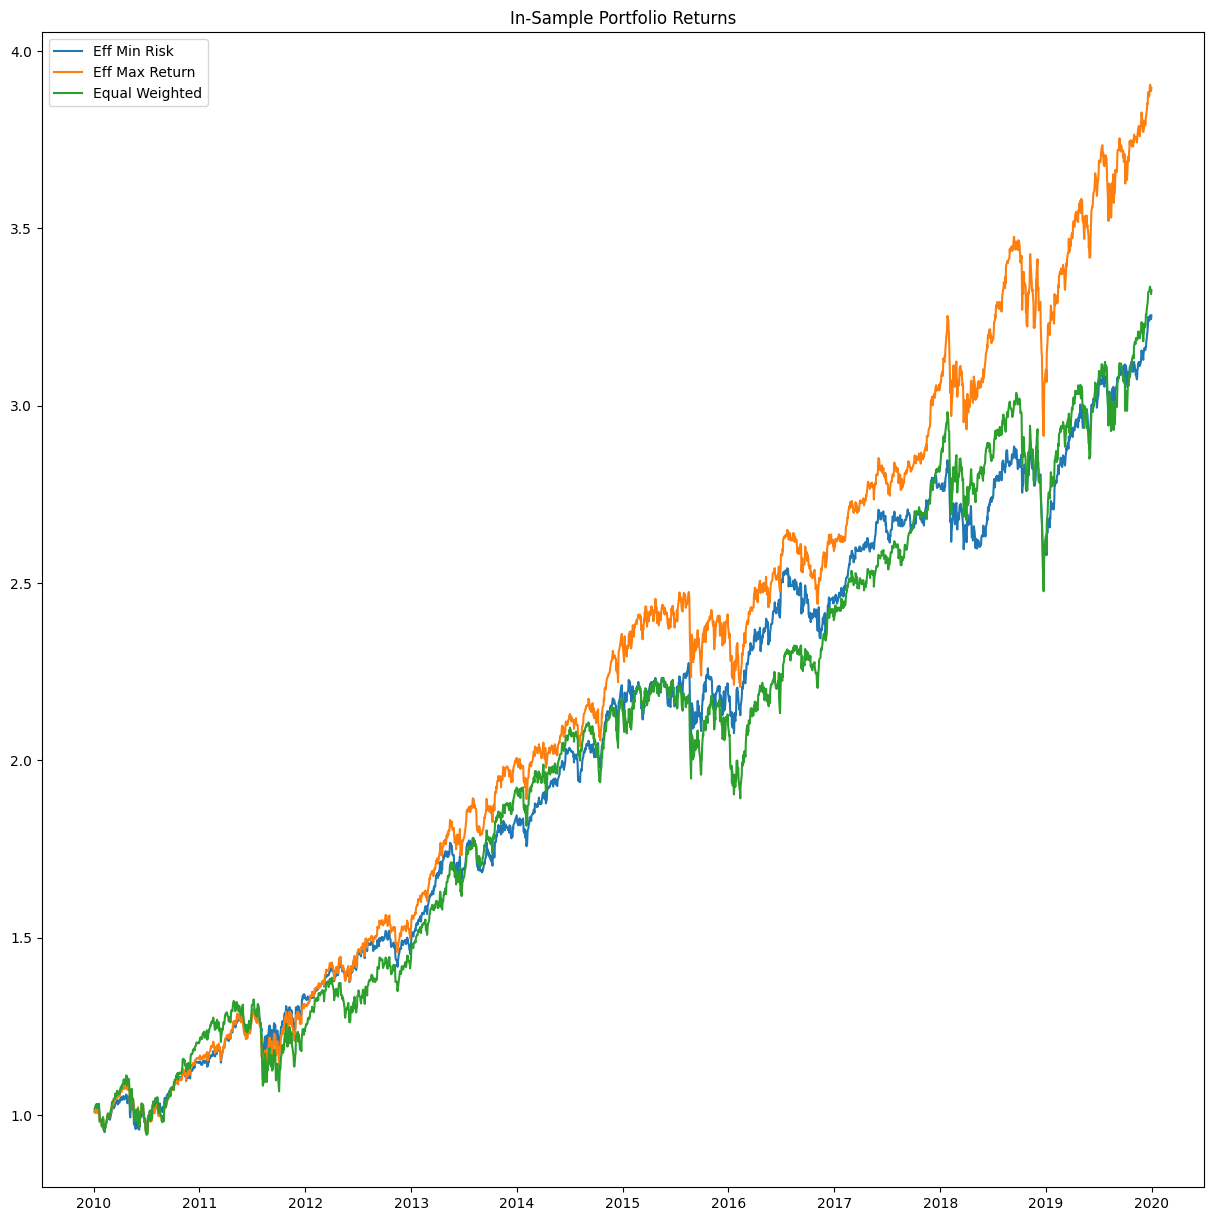

In [22]:
plt.figure(figsize=[15,15])
plt.plot(Eff10_min_ret['PnL'], 
         label = 'Eff Min Risk')
plt.plot(Eff10_max_ret['PnL'], 
         label = 'Eff Max Return')
plt.plot((1+Ind10.loc[train_start:train_end].mean(axis = 1)/100).cumprod(), 
         label = 'Equal Weighted')
plt.title("In-Sample Portfolio Returns")
plt.legend()
plt.show()

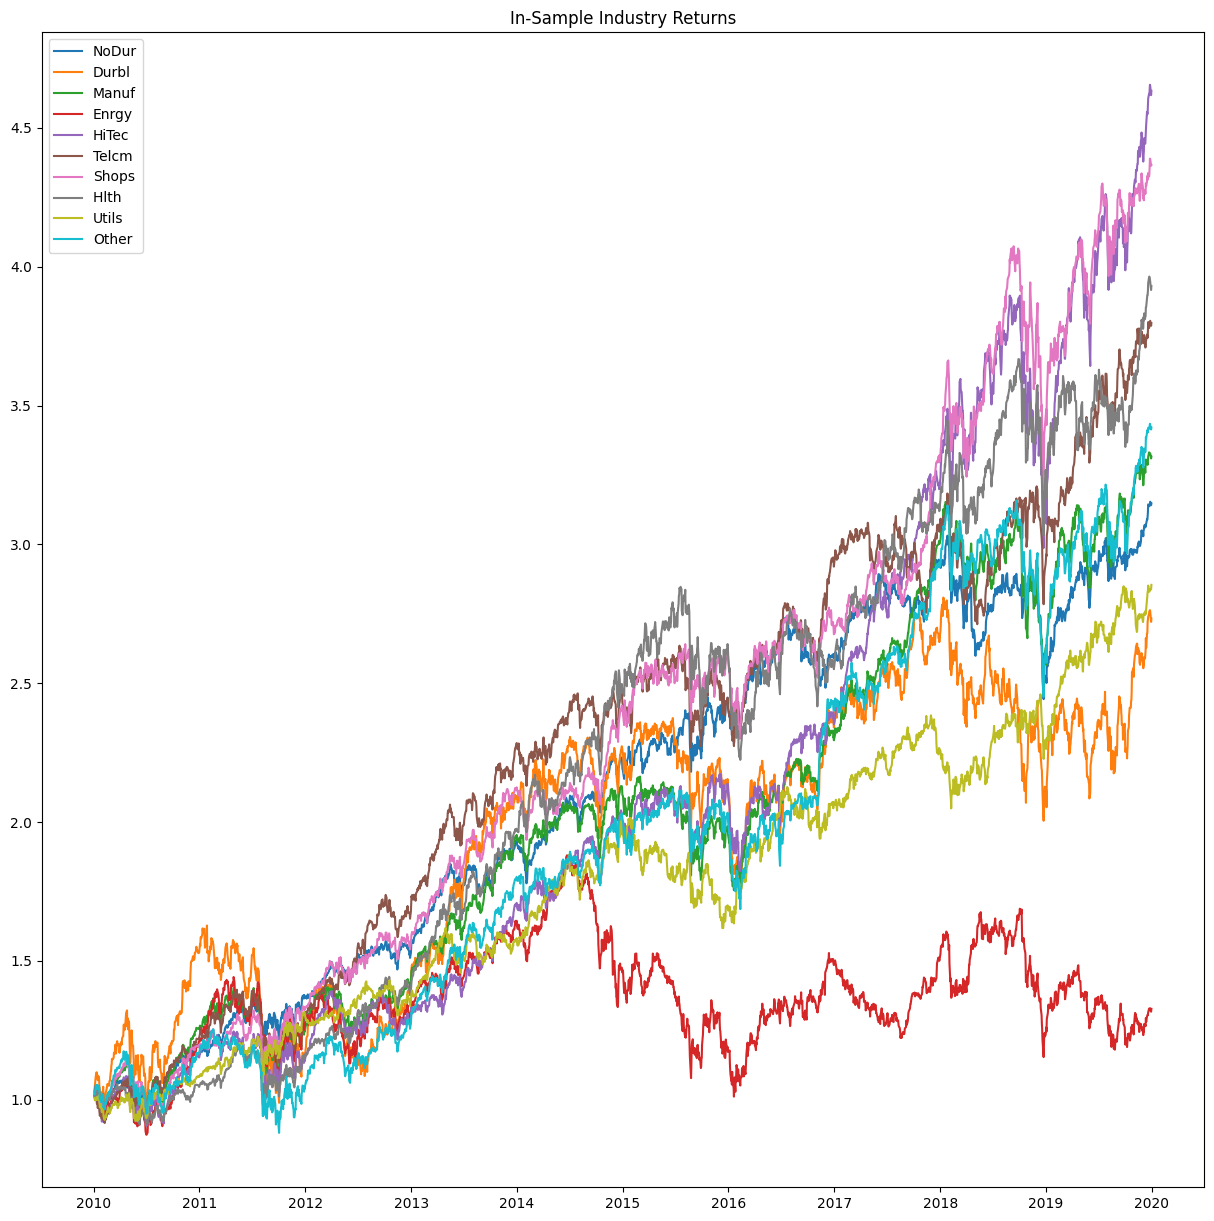

In [23]:
plt.figure(figsize=[15,15])
for col in Ind10.columns:
    Ind_PnL =\
        (1 + Ind10.loc[train_start:train_end,col]/100).cumprod()
    plt.plot(Ind_PnL, label = col)
plt.title("In-Sample Industry Returns")
plt.legend()
plt.show()

##### <a id = "p16"> </a> 1.6 Out-Of-Sample Performance [back to table of contents](#top)

In [24]:
def perform(Ind_daily, w_df):

    ret =\
        Daily_ret(Ind_daily, w_df)
    
    metrics =\
    {
        'Performance':
        [
            ret['PnL'][-1]**(252/len(ret))-1,
            ret['PnL'][-1]-1,        
            ret['ret'].std()*252**0.5,                    
            VaR_hist(ret, 0.01),

            VaR_hist(ret, 0.05),            
            
        ],        
    }
    metrics =\
        pd.DataFrame(metrics)
    metrics.index =\
    [
        'Ann. Return', 
        'Total Return',   
        'Ann. Vol',     
        'VaR 1d 1% - Actual',
        'VaR 1d 5% - Actual',
    ]
    return metrics, ret

In [25]:
idx_os =\
    Ind10.loc[train_end:final_test].index
if final_test in idx_os:
    idx_os = idx_os[:-1]
Eff10_min_w_os =\
    w_construct(idx_os, Ind10.columns, Eff10_min[0])
Eff10_max_w_os =\
    w_construct(idx_os, Ind10.columns, Eff10_max[0])
Eff10_max_w_os

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,Sum_w
2020-01-02,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-03,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-06,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-07,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2020-01-08,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2024-02-26,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2024-02-27,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0
2024-02-28,0.087845,0.0,0.0,0.0,0.000002,0.12051,0.490989,0.115402,0.185252,0.0,1.0


In [26]:
Eff10_min_OS, Eff10_min_OS_ret =\
    perform(Ind10, Eff10_min_w_os)
Eff10_min_OS.columns = ['Min Risk Port - OS']
Eff10_min_OS

,Min Risk Port - OS
Ann. Return,0.057329
Total Return,0.260631
Ann. Vol,0.195790
VaR 1d 1% - Actual,0.037433
VaR 1d 5% - Actual,0.016529


In [27]:
Eff10_max_OS, Eff10_max_OS_ret =\
    perform(Ind10, Eff10_max_w_os)
Eff10_max_OS.columns = ['Max Return Port - OS']
Eff10_max_OS

,Max Return Port - OS
Ann. Return,0.092859
Total Return,0.446186
Ann. Vol,0.199579
VaR 1d 1% - Actual,0.038762
VaR 1d 5% - Actual,0.017843


In [28]:
def view_port(pnl_df, name="Returns"):
    plt.figure(figsize=[15,15])
    for col in pnl_df.columns:
        pnl =\
            pnl_df[col]
        plt.plot(pnl, label = col)
    plt.title(name)
    plt.legend()
    plt.show()
    return

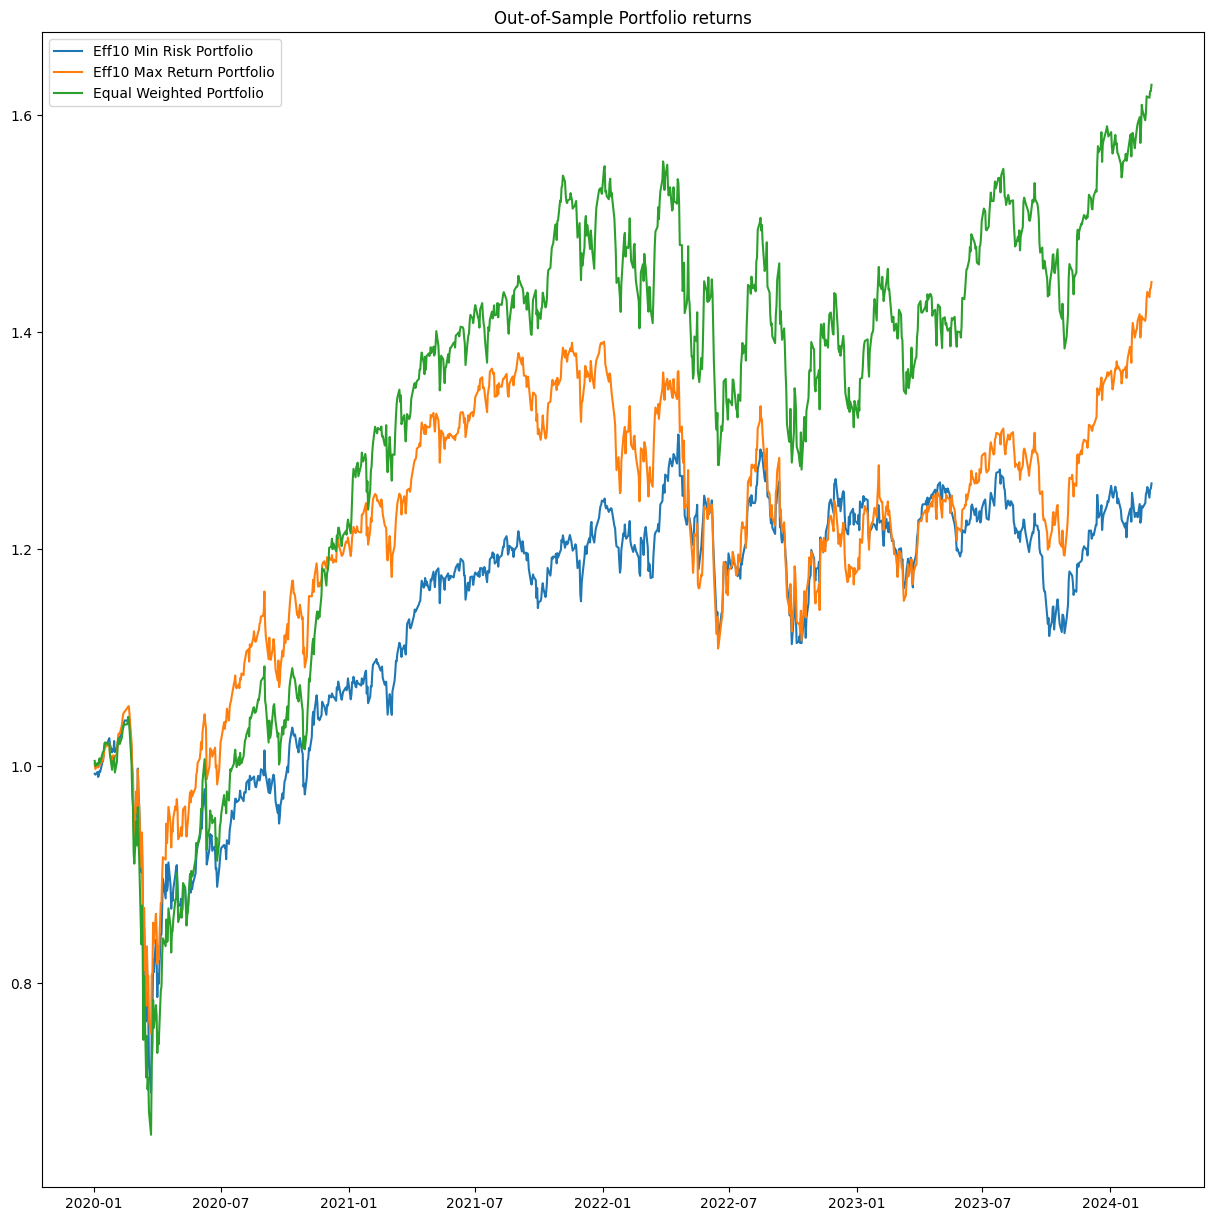

In [29]:
Eff10_port_OS =\
    pd.concat([Eff10_min_OS_ret['PnL'], 
               Eff10_max_OS_ret['PnL'],
              (1+Ind10.loc[train_end:final_test].mean(axis = 1)/100).cumprod()], 
              axis = 1)
Eff10_port_OS.columns =\
    ['Eff10 Min Risk Portfolio',
     'Eff10 Max Return Portfolio', 
     'Equal Weighted Portfolio']
view_port(Eff10_port_OS, 'Out-of-Sample Portfolio returns')

In [30]:
def view_asset(Ind_daily, start, end, name='Returns'):
    plt.figure(figsize=[15,15])
    for col in Ind_daily.columns:
        Ind_PnL =\
            (1 + Ind_daily.loc[start:end,col]/100).cumprod()
        plt.plot(Ind_PnL, label = col)
    plt.title(name)
    plt.legend()
    plt.show()    
    return

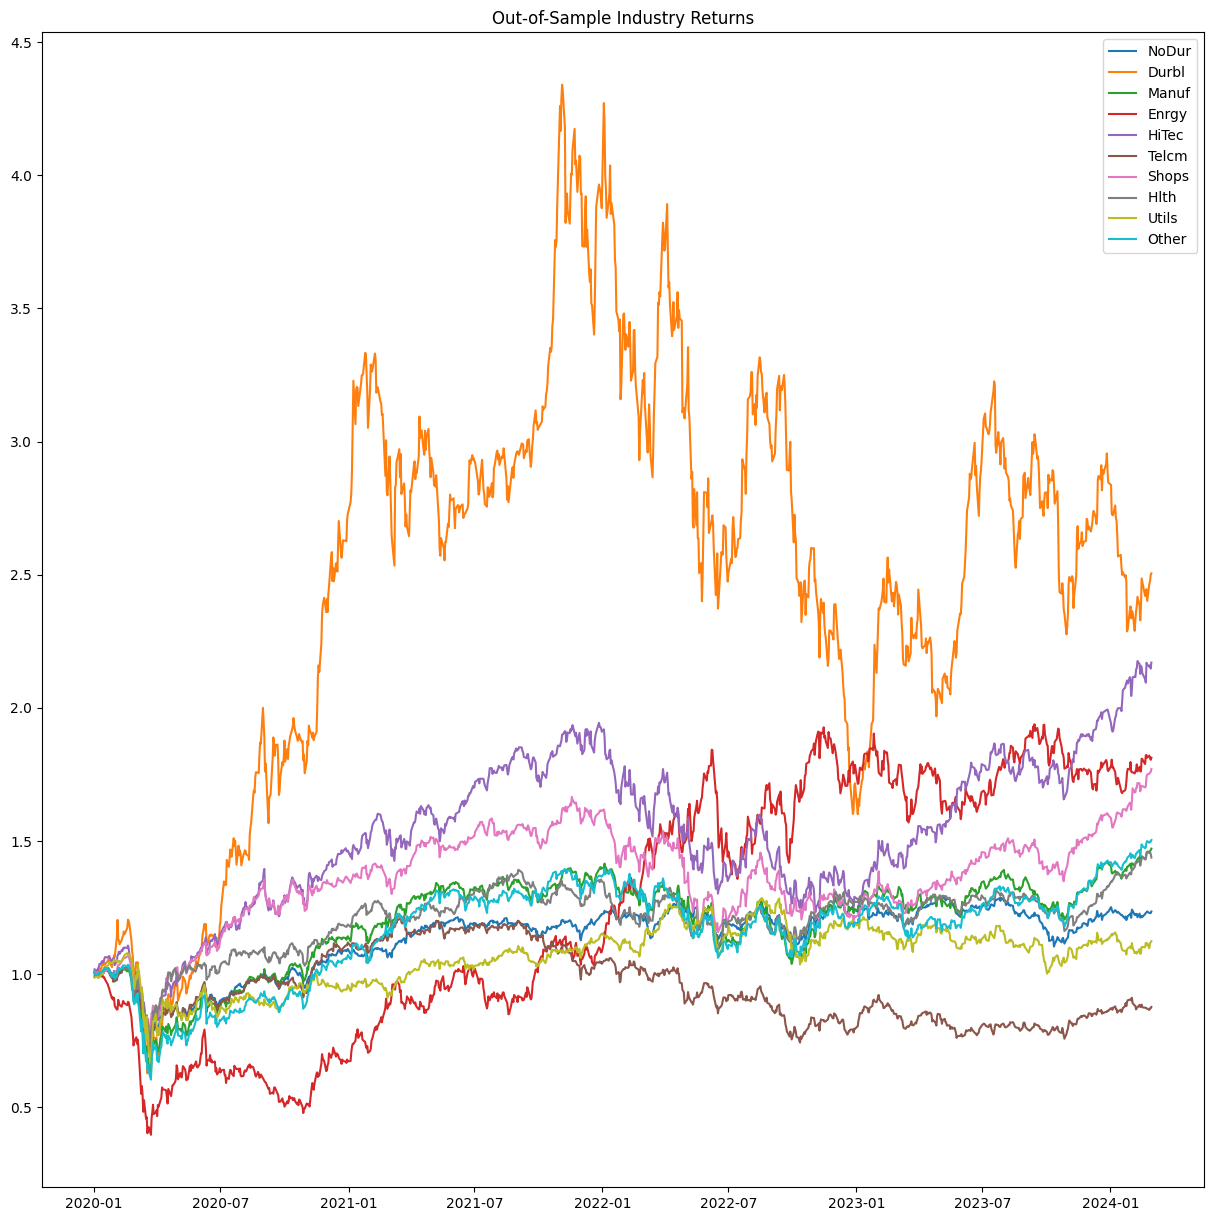

In [31]:
view_asset(Ind10, train_end, final_test, "Out-of-Sample Industry Returns")

## <a id = "p2"> 2. </a> Strategy Tuning [back to table of contents](#top)
* Efficiency frontier
* Rolling window
* Diversity effects
* Shorting effects
* Risk Management
* Model Decision

##### <a id = "p21"> </a> 2.1 Efficiency frontier [back to table of contents](#top)

In [32]:
pre_start = '19900101'

In [33]:
# Generate Weightage
new_Eff10_min, new_Eff10_max =\
   Eff_Front(Ind10, pre_start, train_start, Bounds(0,1)) 

In [34]:
# construct holding weightage indexed by In-Sample date tags
idx =\
    Ind10.loc[train_start:train_end].index
if train_end in idx:
    idx = idx[:-1]
new_Eff10_min_w =\
    w_construct(idx, Ind10.columns, new_Eff10_min[0])
new_Eff10_max_w =\
    w_construct(idx, Ind10.columns, new_Eff10_max[0])

In [35]:
# Establish the In-Sample daily performance
new_Eff10_min_ret =\
    Daily_ret(Ind10, new_Eff10_min_w)
new_Eff10_max_ret =\
    Daily_ret(Ind10, new_Eff10_max_w)

In [36]:
# Consolidate In-Sample Performance Metrics
new_Eff10_result =\
{
    'Min Risk Port.':
    [
        new_Eff10_min_ret['PnL'][-1]**(252/len(new_Eff10_min_ret))-1,
        new_Eff10_min_ret['PnL'][-1]-1,
        new_Eff10_min_ret['ret'].std()*252**0.5,
        VaR_para(new_Eff10_min_ret, 0.01),
        VaR_hist(new_Eff10_min_ret, 0.01),
        VaR_para(new_Eff10_min_ret, 0.05),
        VaR_hist(new_Eff10_min_ret, 0.05),
    ],
    'Max Return Port.':
    [
        new_Eff10_max_ret['PnL'][-1]**(252/len(new_Eff10_max_ret))-1,
        new_Eff10_max_ret['PnL'][-1]-1,
        new_Eff10_max_ret['ret'].std()*252**0.5,
        VaR_para(new_Eff10_max_ret, 0.01),
        VaR_hist(new_Eff10_max_ret, 0.01),
        VaR_para(new_Eff10_max_ret, 0.05),
        VaR_hist(new_Eff10_max_ret, 0.05),
    ],
}


new_Eff10_result =\
    pd.DataFrame(new_Eff10_result)


new_Eff10_result.index =\
[
#     'expected Ann. Return',
    'Ann. Return', 
    'Total Return',
#     'expected Ann. Vol.',    
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
]


new_Eff10_result

,Min Risk Port.,Max Return Port.
Ann. Return,0.121141,0.115481
Total Return,2.131939,1.977609
Ann. Vol,0.118369,0.126902
VaR 1d 1% - para,0.016865,0.018131
VaR 1d 1% - hist,0.020492,0.023040
VaR 1d 5% - para,0.011783,0.012683
VaR 1d 5% - hist,0.011658,0.012958


In [37]:
Eff10_result

,Min Risk Port.,Max Return Port.
Ann. Return,0.125465,0.145913
Total Return,2.254661,2.895638
Ann. Vol,0.117996,0.126667
VaR 1d 1% - para,0.016795,0.017990
VaR 1d 1% - hist,0.020816,0.024458
VaR 1d 5% - para,0.011729,0.012552
VaR 1d 5% - hist,0.011673,0.012739


In [38]:
# construct holding weightage indexed by Out-of-Sample date tags
idx_os =\
    Ind10.loc[train_end:final_test].index
if final_test in idx_os:
    idx_os = idx_os[:-1]
new_Eff10_min_w_os =\
    w_construct(idx_os, Ind10.columns, new_Eff10_min[0])
new_Eff10_max_w_os =\
    w_construct(idx_os, Ind10.columns, new_Eff10_max[0])

In [39]:
new_Eff10_min_OS, new_Eff10_min_OS_ret =\
    perform(Ind10, new_Eff10_min_w_os)
new_Eff10_min_OS.columns = ['Min Risk Port - OS']
new_Eff10_max_OS, new_Eff10_max_OS_ret =\
    perform(Ind10, new_Eff10_max_w_os)
new_Eff10_max_OS.columns = ['Max Return Port - OS']

new_Eff10_result_OS =\
    pd.concat([new_Eff10_min_OS, new_Eff10_max_OS], axis = 1)
new_Eff10_result_OS

,Min Risk Port - OS,Max Return Port - OS
Ann. Return,0.048996,0.088060
Total Return,0.219861,0.419983
Ann. Vol,0.198415,0.202638
VaR 1d 1% - Actual,0.038505,0.039456
VaR 1d 5% - Actual,0.016840,0.017346


In [40]:
Eff10_result_OS =\
    pd.concat([Eff10_min_OS, Eff10_max_OS], axis = 1)
Eff10_result_OS

,Min Risk Port - OS,Max Return Port - OS
Ann. Return,0.057329,0.092859
Total Return,0.260631,0.446186
Ann. Vol,0.195790,0.199579
VaR 1d 1% - Actual,0.037433,0.038762
VaR 1d 5% - Actual,0.016529,0.017843


> ### <span style="color:red;">Including more history does not necessarily improves performance</span>

##### <a id = "p22"> </a> 2.2 Rolling Window [back to table of contents](#top)
* rebalance every N=9 months
* take prior multiple=4 of N as base

In [41]:
today = datetime.datetime.today()
print(today.strftime('%Y%m%d'))
print(today.strftime("%Y-%m-%d"))

today

20240428
2024-04-28


datetime.datetime(2024, 4, 28, 23, 9, 33, 716060)

In [42]:
def gen_date_tag(start_date, end_date, m, multi=2, form='%Y%m%d'):
    date_tags = []
    train_tags = []
    # Convert the input string to a datetime object
    input_date = datetime.datetime.strptime(start_date, form)
    
    while input_date < datetime.datetime.strptime(end_date, form):
        # Format the result date as a string in 'YYYY-MM-DD' format
        date_tags.append(input_date.strftime(form))
        train_date =\
            input_date - relativedelta(months=m*multi)
        train_tags.append(train_date.strftime(form))
        # Move to the next date `m` months later
        input_date += relativedelta(months=m)
    date_tags.append(end_date)
    return date_tags, train_tags

In [43]:
test_date_tag, train_date_tag =\
    gen_date_tag(train_start, train_end, 12, 2)

print(test_date_tag); print(train_date_tag)

['20100101', '20110101', '20120101', '20130101', '20140101', '20150101', '20160101', '20170101', '20180101', '20190101', '20200101']
['20080101', '20090101', '20100101', '20110101', '20120101', '20130101', '20140101', '20150101', '20160101', '20170101']


In [44]:
# def Eff_Front(Ind_daily, start, end, bounds = Bounds(0,1)):

In [45]:
def Roll_Eff(Ind_daily, start, end, 
             m, multi=4, bounds = Bounds(0,1)):
    
    test_tag, train_tag =\
        gen_date_tag(start, end, m, multi)    

    Roll_Min_w =\
        pd.DataFrame(index = Ind_daily.loc[start:end].index, 
                     columns = Ind_daily.columns)
    
    Roll_Max_w =\
        pd.DataFrame(index = Ind_daily.loc[start:end].index, 
                     columns = Ind_daily.columns)
    
    for i in range(len(train_tag)):
        
        temp_min_risk, temp_max_ret =\
           Eff_Front(Ind_daily, train_tag[i], test_tag[i], bounds)
        
        Roll_Min_w.loc[test_tag[i]:test_tag[i+1]] =\
            temp_min_risk[0]
        Roll_Max_w.loc[test_tag[i]:test_tag[i+1]] =\
            temp_max_ret[0]
    if end in Roll_Min_w.index:
        Roll_Min_w = Roll_Min_w[:-1]
    Roll_Min_w['Sum_w'] = Roll_Min_w.sum(axis=1) 
    
    if end in Roll_Max_w.index:
        Roll_Max_w = Roll_Max_w[:-1] 
    Roll_Max_w['Sum_w'] = Roll_Max_w.sum(axis=1)
    
    return Roll_Min_w, Roll_Max_w


In [46]:
def diverse_roll(Ind_daily, start, end, 
             m, multi=4, bounds = Bounds(0,1)):
    Roll_Eff_min_w, Roll_Eff_max_w =\
        Roll_Eff(Ind_daily, start, end, m, multi, bounds)    
    Roll_Eff_min_ret =\
        Daily_ret(Ind10, Roll_Eff_min_w)
    Roll_Eff_max_ret =\
        Daily_ret(Ind10, Roll_Eff_max_w)
    
    # Consolidate In-Sample Performance Metrics
    Roll_Eff_result =\
    {
        'Roll Min Risk Port.':
        [

            Roll_Eff_min_ret['PnL'][-1]**(252/len(Roll_Eff_min_ret))-1,
            Roll_Eff_min_ret['PnL'][-1]-1,

            Roll_Eff_min_ret['ret'].std()*252**0.5,
            VaR_para(Roll_Eff_min_ret, 0.01),
            VaR_hist(Roll_Eff_min_ret, 0.01),
            VaR_para(Roll_Eff_min_ret, 0.05),
            VaR_hist(Roll_Eff_min_ret, 0.05),
        ],
        'Roll Max Return Port.':
        [

            Roll_Eff_max_ret['PnL'][-1]**(252/len(Roll_Eff_max_ret))-1,
            Roll_Eff_max_ret['PnL'][-1]-1,

            Roll_Eff_max_ret['ret'].std()*252**0.5,
            VaR_para(Roll_Eff_max_ret, 0.01),
            VaR_hist(Roll_Eff_max_ret, 0.01),
            VaR_para(Roll_Eff_max_ret, 0.05),
            VaR_hist(Roll_Eff_max_ret, 0.05),
        ],
    }


    Roll_Eff_result =\
        pd.DataFrame(Roll_Eff_result)


    Roll_Eff_result.index =\
    [

        'Ann. Return', 
        'Total Return',

        'Ann. Vol',     
        'VaR 1d 1% - para',
        'VaR 1d 1% - hist',
        'VaR 1d 5% - para',
        'VaR 1d 5% - hist',
    ]

    
    return [Roll_Eff_result, Roll_Eff_min_ret, Roll_Eff_max_ret]

In [47]:
Roll_Eff10_min_w, Roll_Eff10_max_w =\
    Roll_Eff(Ind10, train_start, train_end, 12, 2, Bounds(0, 1))

In [48]:
# Establish the In-Sample daily performance
Roll_Eff10_min_ret =\
    Daily_ret(Ind10, Roll_Eff10_min_w)
Roll_Eff10_max_ret =\
    Daily_ret(Ind10, Roll_Eff10_max_w)

In [49]:
# Consolidate In-Sample Performance Metrics
Roll_Eff10_result =\
{
    'Roll Min Risk Port.':
    [

        Roll_Eff10_min_ret['PnL'][-1]**(252/len(Roll_Eff10_min_ret))-1,
        Roll_Eff10_min_ret['PnL'][-1]-1,

        Roll_Eff10_min_ret['ret'].std()*252**0.5,
        VaR_para(Roll_Eff10_min_ret, 0.01),
        VaR_hist(Roll_Eff10_min_ret, 0.01),
        VaR_para(Roll_Eff10_min_ret, 0.05),
        VaR_hist(Roll_Eff10_min_ret, 0.05),
    ],
    'Roll Max Return Port.':
    [

        Roll_Eff10_max_ret['PnL'][-1]**(252/len(Roll_Eff10_max_ret))-1,
        Roll_Eff10_max_ret['PnL'][-1]-1,

        Roll_Eff10_max_ret['ret'].std()*252**0.5,
        VaR_para(Roll_Eff10_max_ret, 0.01),
        VaR_hist(Roll_Eff10_max_ret, 0.01),
        VaR_para(Roll_Eff10_max_ret, 0.05),
        VaR_hist(Roll_Eff10_max_ret, 0.05),
    ],
}


Roll_Eff10_result =\
    pd.DataFrame(Roll_Eff10_result)


Roll_Eff10_result.index =\
[

    'Ann. Return', 
    'Total Return',
  
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
]


Roll_Eff10_result

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.126803,0.093310
Total Return,2.293485,1.436783
Ann. Vol,0.119180,0.145757
VaR 1d 1% - para,0.016963,0.020964
VaR 1d 1% - hist,0.020883,0.028327
VaR 1d 5% - para,0.011847,0.014706
VaR 1d 5% - hist,0.011813,0.014534


In [50]:
roll_selects = {}
window_list = [7, 9, 11, 12]
multi_list = [1, 2, 4, 5]

for window in window_list:
    for multiple in multi_list:
        key = f'w{window}m{multiple}'
        roll_selects[key] =\
            diverse_roll(Ind10, 
                         train_start,
                         train_end,
                         window, 
                         multiple, 
                         Bounds(0,1))


In [51]:
for key, data in roll_selects.items():
    print(key)
    print(data[0])

w7m1
                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                  0.130616               0.124249
Total Return                 2.406476               2.219727
Ann. Vol                     0.117106               0.157693
VaR 1d 1% - para             0.016647               0.022595
VaR 1d 1% - hist             0.020014               0.028639
VaR 1d 5% - para             0.011620               0.015825
VaR 1d 5% - hist             0.011405               0.016165
w7m2
                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                  0.130073               0.139037
Total Return                 2.390161               2.668437
Ann. Vol                     0.117665               0.156293
VaR 1d 1% - para             0.016731               0.022339
VaR 1d 1% - hist             0.020651               0.029794
VaR 1d 5% - para             0.011679               0.015629
VaR 1d 5% - hist             0.011566               0.015875
w7m4
         

> ### <span style="color:red;">Rolling Effect observation:</span> 
1. more frequent rebalancing may not necessarily generate good result
2. Max Return portfolio may not necessarily gives higher return than Min Risk portfolios, maybe due to strategy crowdedness, or market regime characters
3. rolling window of 12m deemed to be a very crowded strategy, and thus the result is not as good
4. Some good result combiniations :
* rebalanceng 9 months with 5 times prior window
* rebalanceng 11 months with 4 times prior window
* rebalanceng 7 months with 2 times prior window

##### <a id = "p23"> </a> 2.3 Diversity Effect [back to table of contents](#top)

In [52]:
# def diverse_roll(Ind_daily, start, end, 
#              m, multi=4, bounds = Bounds(0,1)):
#     Roll_Eff_min_w, Roll_Eff_max_w =\
#         Roll_Eff(Ind_daily, start, end, m, multi, bounds)    
#     Roll_Eff_min_ret =\
#         Daily_ret(Ind10, Roll_Eff_min_w)
#     Roll_Eff_max_ret =\
#         Daily_ret(Ind10, Roll_Eff_max_w)
    
#     # Consolidate In-Sample Performance Metrics
#     Roll_Eff_result =\
#     {
#         'Roll Min Risk Port.':
#         [

#             Roll_Eff_min_ret['PnL'][-1]**(252/len(Roll_Eff_min_ret))-1,
#             Roll_Eff_min_ret['PnL'][-1]-1,

#             Roll_Eff_min_ret['ret'].std()*252**0.5,
#             VaR_para(Roll_Eff_min_ret, 0.01),
#             VaR_hist(Roll_Eff_min_ret, 0.01),
#             VaR_para(Roll_Eff_min_ret, 0.05),
#             VaR_hist(Roll_Eff_min_ret, 0.05),
#         ],
#         'Roll Max Return Port.':
#         [

#             Roll_Eff_max_ret['PnL'][-1]**(252/len(Roll_Eff_max_ret))-1,
#             Roll_Eff_max_ret['PnL'][-1]-1,

#             Roll_Eff_max_ret['ret'].std()*252**0.5,
#             VaR_para(Roll_Eff_max_ret, 0.01),
#             VaR_hist(Roll_Eff_max_ret, 0.01),
#             VaR_para(Roll_Eff_max_ret, 0.05),
#             VaR_hist(Roll_Eff_max_ret, 0.05),
#         ],
#     }


#     Roll_Eff_result =\
#         pd.DataFrame(Roll_Eff_result)


#     Roll_Eff_result.index =\
#     [

#         'Ann. Return', 
#         'Total Return',

#         'Ann. Vol',     
#         'VaR 1d 1% - para',
#         'VaR 1d 1% - hist',
#         'VaR 1d 5% - para',
#         'VaR 1d 5% - hist',
#     ]

    
#     return [Roll_Eff_result, Roll_Eff_min_ret, Roll_Eff_max_ret]

In [53]:
diverse_results = []
diverse_results +=\
    [diverse_roll(Ind5, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind12, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind17, train_start, train_end, 9, 4, Bounds(0,1))]
diverse_results +=\
    [diverse_roll(Ind30, train_start, train_end, 9, 4, Bounds(0,1))]

In [54]:
# 5 Industry Portfolios
diverse_results[0][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.066512,0.094091
Total Return,0.902007,1.454235
Ann. Vol,0.076457,0.125547
VaR 1d 1% - para,0.010937,0.018010
VaR 1d 1% - hist,0.014890,0.024675
VaR 1d 5% - para,0.007655,0.012620
VaR 1d 5% - hist,0.006927,0.012742


In [55]:
# 10 Industry Portfolios
diverse_results[1][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141528
Total Return,2.173295,2.749325
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315


In [56]:
# 12 Industry Portfolios
diverse_results[2][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.118496,0.111045
Total Return,2.058937,1.861472
Ann. Vol,0.117089,0.113821
VaR 1d 1% - para,0.016687,0.016236
VaR 1d 1% - hist,0.019747,0.021079
VaR 1d 5% - para,0.011661,0.011350
VaR 1d 5% - hist,0.011716,0.011310


In [57]:
# 17 Industry Portfolios
diverse_results[3][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.019154,0.011723
Total Return,0.208559,0.123404
Ann. Vol,0.028668,0.018817
VaR 1d 1% - para,0.004124,0.002711
VaR 1d 1% - hist,0.005384,0.004180
VaR 1d 5% - para,0.002894,0.001903
VaR 1d 5% - hist,0.003004,0.001016


In [58]:
# 30 Industry Portfolios
diverse_results[4][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.012608,0.014275
Total Return,0.133253,0.152015
Ann. Vol,0.023613,0.027278
VaR 1d 1% - para,0.003410,0.003940
VaR 1d 1% - hist,0.004797,0.006246
VaR 1d 5% - para,0.002396,0.002769
VaR 1d 5% - hist,0.002199,0.001998


> ### <span style="color:red;">A more diversed industry portfolio would improve in reducing volitality, by trading-off on returns</span>

##### <a id = "p24"> </a> 2.4 Shorting Effect [back to table of contents](#top)

In [59]:
short_results = []
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(0,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-0.25,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-0.5,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-0.75,1))]
short_results +=\
    [diverse_roll(Ind10, train_start, train_end, 9, 4, Bounds(-1,1))]

In [60]:
short_results[0][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141528
Total Return,2.173295,2.749325
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315


In [61]:
short_results[1][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.143482,0.141219
Total Return,2.813902,2.739217
Ann. Vol,0.111536,0.149473
VaR 1d 1% - para,0.015788,0.021336
VaR 1d 1% - hist,0.019782,0.027351
VaR 1d 5% - para,0.011000,0.014919
VaR 1d 5% - hist,0.010666,0.014506


In [62]:
short_results[2][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.142974,0.148405
Total Return,2.797005,2.981059
Ann. Vol,0.111706,0.165654
VaR 1d 1% - para,0.015815,0.023672
VaR 1d 1% - hist,0.019782,0.030087
VaR 1d 5% - para,0.011019,0.016561
VaR 1d 5% - hist,0.010738,0.016167


In [63]:
short_results[3][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.142974,0.159155
Total Return,2.797005,3.369146
Ann. Vol,0.111706,0.176561
VaR 1d 1% - para,0.015815,0.025226
VaR 1d 1% - hist,0.019782,0.032308
VaR 1d 5% - para,0.011019,0.017646
VaR 1d 5% - hist,0.010738,0.017460


In [64]:
short_results[4][0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.142974,0.163027
Total Return,2.797005,3.517081
Ann. Vol,0.111706,0.184302
VaR 1d 1% - para,0.015815,0.026342
VaR 1d 1% - hist,0.019782,0.033327
VaR 1d 5% - para,0.011019,0.018430
VaR 1d 5% - hist,0.010738,0.018078


> ### <span style="color:red;">Allowing short position would improve on returns, by trading-off on volitality </span>

##### <a id = "p25"> </a> 2.5 Risk Management [back to table of contents](#top)

In [65]:
rm_target = roll_selects['w9m4']
rm_target[0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141528
Total Return,2.173295,2.749325
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315


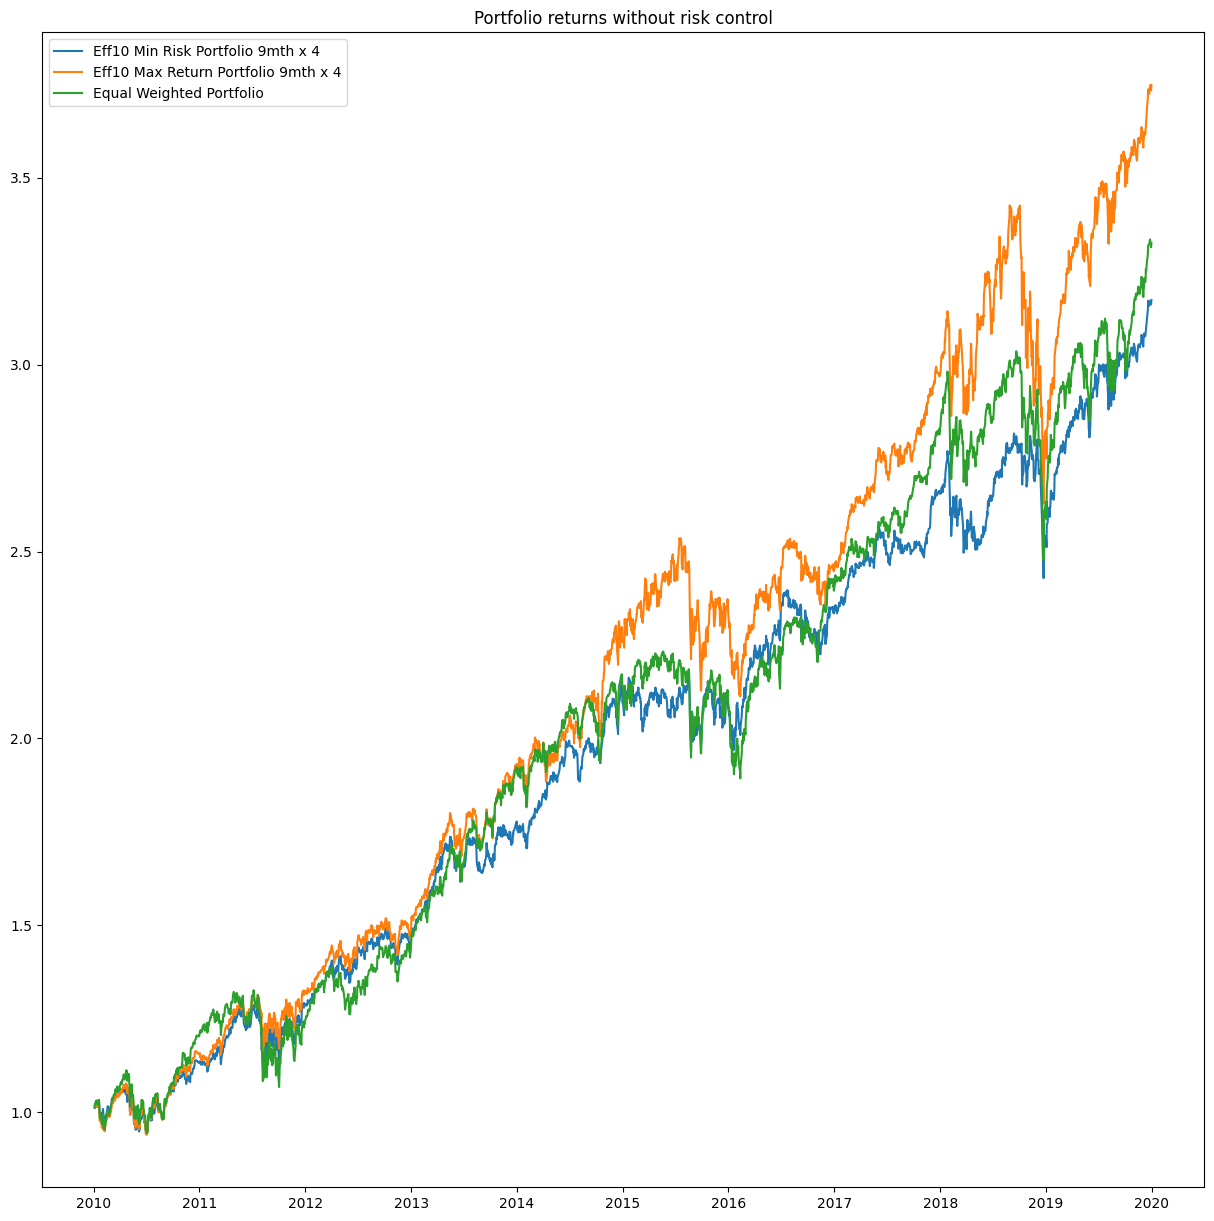

In [66]:
current_port =\
    pd.concat([rm_target[1]['PnL'], 
               rm_target[2]['PnL'],
              (1+Ind10.loc[train_start:train_end].mean(axis = 1)/100).cumprod()], 
              axis = 1)
current_port.columns =\
    ['Eff10 Min Risk Portfolio 9mth x 4',
     'Eff10 Max Return Portfolio 9mth x 4', 
     'Equal Weighted Portfolio']
view_port(current_port, 'Portfolio returns without risk control')

In [67]:
rebalance_test_tag, rebalance_train_tag =\
    gen_date_tag(train_start, train_end, 9, 4)
rebalance_test_tag

['20100101',
 '20101001',
 '20110701',
 '20120401',
 '20130101',
 '20131001',
 '20140701',
 '20150401',
 '20160101',
 '20161001',
 '20170701',
 '20180401',
 '20190101',
 '20191001',
 '20200101']

In [68]:
rm_min_threshold =\
    rm_target[0].loc['VaR 1d 5% - hist','Roll Min Risk Port.']
rm_max_threshold =\
    rm_target[0].loc['VaR 1d 5% - hist','Roll Max Return Port.']
rm_min_threshold, rm_max_threshold

(0.01203944905103654, 0.014314953314029268)

In [69]:
def risk_control(pnl_df, threshold, rebalance_idx, strike=2):
    pnl = pnl_df.copy()
    rebalance_idx = pd.to_datetime(rebalance_idx)
#     pnl.index =\
#         pnl.index.strftime('%Y-%m-%d')
    pnl['pct_change'] =\
        pnl['PnL']\
        .pct_change()
    pnl['pct_change'][0] =\
        pnl['PnL'][0] - 1
    pnl['PnL_rm'] = 0
    pnl['PnL_rm'][0] = pnl['PnL'][0]
    
    risk_management = 0
    current_strike = 0
    for idx in pnl.index:
        if pnl.loc[idx, 'ret'] < -threshold:
            current_strike += 1

            if current_strike >= strike:
                print("2nd strike: ", idx)

                current_strike = 0
                risk_management += 1
                clear_start =\
                    pnl.index[pnl.index.get_loc(idx)+1]
                
                for re_idx in rebalance_idx:
                    clear_end = re_idx
                    if clear_end > clear_start:
                        break
                print(f"risk control No. {risk_management}")
                print(f"from {clear_start} to {clear_end}")
                pnl.loc[clear_start:clear_end, 'pct_change'] = 0
            continue
        current_strike = 0
            
    for i in range(len(pnl)-1):
        pnl.iloc[i+1, -1] =\
            pnl.iloc[i, -1] *\
            (1 + pnl.iloc[i+1, -2])
    
    return pnl

In [70]:
rm_min =\
    risk_control(rm_target[1], rm_min_threshold, rebalance_test_tag, 2)
rm_min =\
    rm_min.rename(columns={'ret': 'old_ret', 
                           'PnL': 'old_PnL',
                           'pct_change': 'ret',
                           'PnL_rm': 'PnL'})
rm_min.tail()

2nd strike:  2011-09-22 00:00:00
risk control No. 1
from 2011-09-23 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-10-03 00:00:00
risk control No. 2
from 2011-10-04 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-11-01 00:00:00
risk control No. 3
from 2011-11-02 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2013-06-20 00:00:00
risk control No. 4
from 2013-06-21 00:00:00 to 2013-10-01 00:00:00
2nd strike:  2014-07-31 00:00:00
risk control No. 5
from 2014-08-01 00:00:00 to 2015-04-01 00:00:00
2nd strike:  2015-08-21 00:00:00
risk control No. 6
from 2015-08-24 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-08-25 00:00:00
risk control No. 7
from 2015-08-26 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-12-03 00:00:00
risk control No. 8
from 2015-12-04 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2018-02-05 00:00:00
risk control No. 9
from 2018-02-06 00:00:00 to 2018-04-01 00:00:00
2nd strike:  2018-03-23 00:00:00
risk control No. 10
from 2018-03-26 00:00:00 to 2018-04-01 00:00:00

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,old_ret,old_PnL,ret,PnL
2019-12-24,-0.00021,0.0,-0.0,0.0,-0.0,0.000192,0.0,0.00002,0.000042,0.000161,0.000206,3.158408,0.000206,2.440940
2019-12-26,0.000499,0.0,0.0,0.0,0.0,0.00047,0.000001,-0.000069,0.000719,0.000803,0.002423,3.166062,0.002423,2.446856
2019-12-27,0.000866,-0.0,0.0,-0.000001,-0.0,0.000075,-0.0,-0.000069,0.000635,-0.000285,0.00122,3.169926,0.001220,2.449842
2019-12-30,-0.00105,-0.0,-0.0,-0.000001,-0.0,-0.000502,-0.0,-0.000213,-0.000127,-0.000785,-0.002679,3.161434,-0.002679,2.443279
2019-12-31,0.000551,0.0,0.0,0.000001,0.0,0.000267,0.0,0.000104,0.002454,0.000375,0.003752,3.173295,0.003752,2.452446


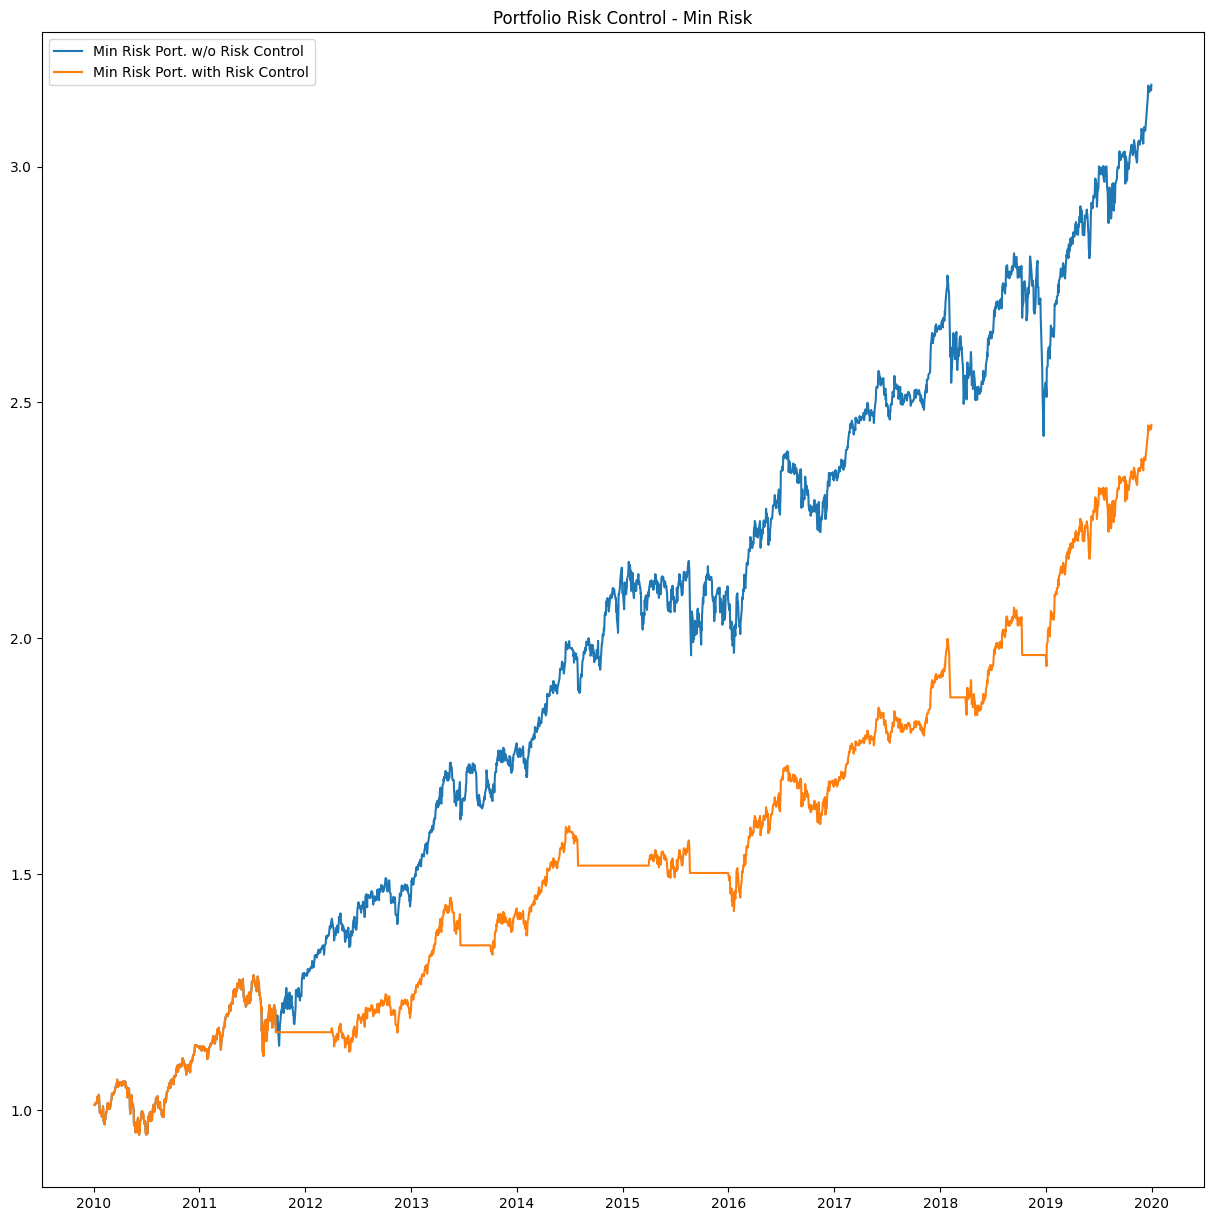

In [71]:
plt.figure(figsize=[15,15])
plt.plot(rm_min['old_PnL'], label = 'Min Risk Port. w/o Risk Control')
plt.plot(rm_min['PnL'], label = 'Min Risk Port. with Risk Control')
plt.title('Portfolio Risk Control - Min Risk')
plt.legend()
plt.show()

In [72]:
rm_max =\
    risk_control(rm_target[2], rm_max_threshold, rebalance_test_tag, 2)

rm_max =\
    rm_max.rename(columns={'ret': 'old_ret', 
                           'PnL': 'old_PnL',
                           'pct_change': 'ret',
                           'PnL_rm': 'PnL'})
rm_max.tail()

2nd strike:  2010-01-22 00:00:00
risk control No. 1
from 2010-01-25 00:00:00 to 2010-10-01 00:00:00
2nd strike:  2011-09-22 00:00:00
risk control No. 2
from 2011-09-23 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-10-03 00:00:00
risk control No. 3
from 2011-10-04 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2011-11-01 00:00:00
risk control No. 4
from 2011-11-02 00:00:00 to 2012-04-01 00:00:00
2nd strike:  2013-06-20 00:00:00
risk control No. 5
from 2013-06-21 00:00:00 to 2013-10-01 00:00:00
2nd strike:  2015-08-21 00:00:00
risk control No. 6
from 2015-08-24 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-09-01 00:00:00
risk control No. 7
from 2015-09-02 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2015-09-28 00:00:00
risk control No. 8
from 2015-09-29 00:00:00 to 2016-01-01 00:00:00
2nd strike:  2018-02-05 00:00:00
risk control No. 9
from 2018-02-06 00:00:00 to 2018-04-01 00:00:00
2nd strike:  2018-03-23 00:00:00
risk control No. 10
from 2018-03-26 00:00:00 to 2018-04-01 00:00:00

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,old_ret,old_PnL,ret,PnL
2019-12-24,-0.0,0.0,-0.0,0.0,-0.000216,0.0,0.000314,0.0,0.000048,0.000048,0.000194,3.725527,0.000194,2.996826
2019-12-26,0.0,0.0,0.0,0.0,0.002412,0.0,0.002044,-0.0,0.000817,0.000239,0.005511,3.74606,0.005511,3.013342
2019-12-27,0.0,-0.0,0.0,-0.0,-0.000278,0.0,-0.000031,-0.0,0.000721,-0.000085,0.000326,3.747281,0.000326,3.014324
2019-12-30,-0.0,-0.0,-0.0,-0.0,-0.002195,-0.0,-0.00088,-0.0,-0.000144,-0.000234,-0.003454,3.734339,-0.003454,3.003914
2019-12-31,0.0,0.0,0.0,0.0,0.00102,0.0,0.000094,0.0,0.002787,0.000112,0.004013,3.749325,0.004013,3.015969


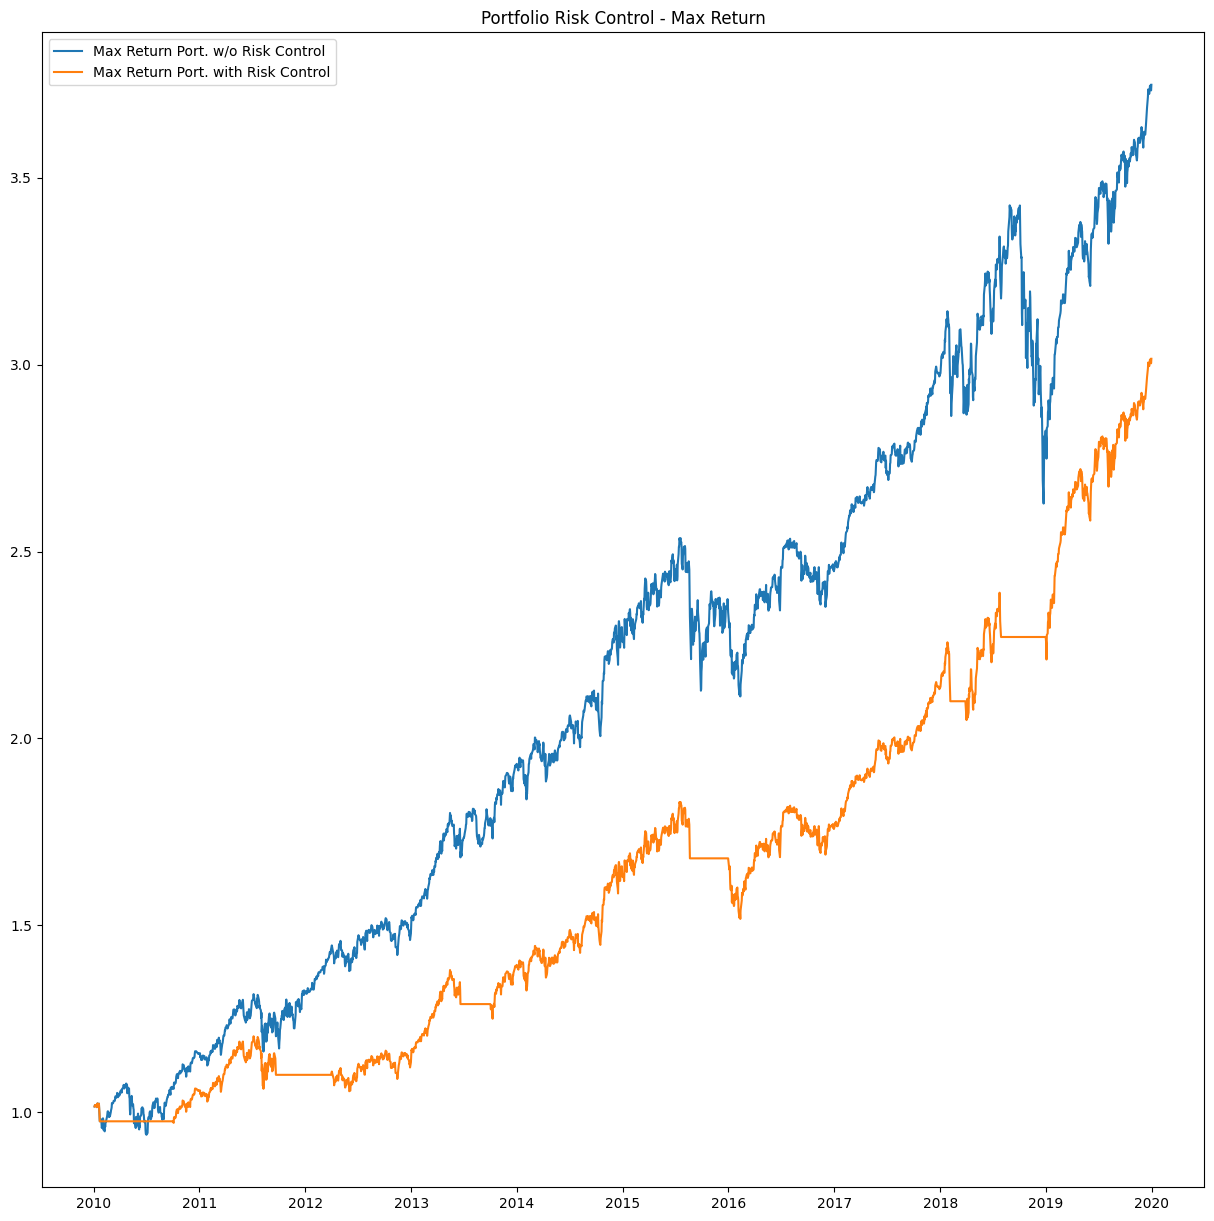

In [73]:
plt.figure(figsize=[15,15])
plt.plot(rm_max['old_PnL'], label = 'Max Return Port. w/o Risk Control')
plt.plot(rm_max['PnL'], label = 'Max Return Port. with Risk Control')
plt.title('Portfolio Risk Control - Max Return')
plt.legend()
plt.show()

In [74]:
# Consolidate In-Sample Performance Metrics
rm_w9m4_result =\
{
    'Roll w9m4 Min Risk Port.':
    [

        rm_min['PnL'][-1]**(252/len(rm_min))-1,
        rm_min['PnL'][-1]-1,

        rm_min['ret'].std()*252**0.5,
        VaR_para(rm_min, 0.01),
        VaR_hist(rm_min, 0.01),
        VaR_para(rm_min, 0.05),
        VaR_hist(rm_min, 0.05),
    ],
    'Roll w9m4 Max Return Port.':
    [

        rm_max['PnL'][-1]**(252/len(rm_max))-1,
        rm_max['PnL'][-1]-1,

        rm_max['ret'].std()*252**0.5,
        VaR_para(rm_max, 0.01),
        VaR_hist(rm_max, 0.01),
        VaR_para(rm_max, 0.05),
        VaR_hist(rm_max, 0.05),
    ],
}


rm_w9m4_result =\
    pd.DataFrame(rm_w9m4_result)


rm_w9m4_result.index =\
[

    'Ann. Return', 
    'Total Return',
  
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
]


rm_w9m4_result

,Roll w9m4 Min Risk Port.,Roll w9m4 Max Return Port.
Ann. Return,0.094011,0.116912
Total Return,1.452446,2.015969
Ann. Vol,0.099271,0.107985
VaR 1d 1% - para,0.014172,0.015363
VaR 1d 1% - hist,0.019241,0.020925
VaR 1d 5% - para,0.009910,0.010727
VaR 1d 5% - hist,0.009407,0.010664


In [75]:
rm_target[0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.122615,0.141528
Total Return,2.173295,2.749325
Ann. Vol,0.119176,0.142263
VaR 1d 1% - para,0.016977,0.020282
VaR 1d 1% - hist,0.020390,0.026229
VaR 1d 5% - para,0.011861,0.014175
VaR 1d 5% - hist,0.012039,0.014315


> ### <span style="color:red;">With proper risk control, the VaR is metrics are enhanced. Further more, the Sharpe for Max Return Portfolio also improved </span>

##### <a id = "p26"> </a> 2.6 Model Decision [back to table of contents](#top)

> <span style="color:red;">Conclusion:</span>
1. choice of less crowded rebalancing windows.
2. Min Risk portfolio tends to excel in shorter horizon.
3. Max Return portfolio tends to excel in longer horizon.
4. Diversity is needed, but not necessarily exhaustive.
5. Portfolio level Risk Management is preferred.
6. With properly tuned risk control, some shorting can be adopted.

In [76]:
Model_Decisions = []
Model_Decisions +=\
    [diverse_roll(Ind10, train_end, final_test, 9, 5, Bounds(0,1))]
Model_Decisions +=\
    [diverse_roll(Ind10, train_end, final_test, 9, 5, Bounds(-0.5,1))]
Model_Decisions +=\
    [diverse_roll(Ind10, train_end, final_test, 11, 4, Bounds(0,1))]
Model_Decisions +=\
    [diverse_roll(Ind10, train_end, final_test, 11, 4, Bounds(-0.5,1))]
Model_Decisions +=\
    [diverse_roll(Ind10, train_end, final_test, 7, 2, Bounds(0,1))]
Model_Decisions +=\
    [diverse_roll(Ind10, train_end, final_test, 7, 2, Bounds(-0.5,1))]

for model in Model_Decisions:
    print(model[0])

                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                  0.030385              -0.005758
Total Return                 0.132428              -0.023708
Ann. Vol                     0.202012               0.290177
VaR 1d 1% - para             0.029404               0.042380
VaR 1d 1% - hist             0.040413               0.053984
VaR 1d 5% - para             0.020732               0.029922
VaR 1d 5% - hist             0.017647               0.028871
                  Roll Min Risk Port.  Roll Max Return Port.
Ann. Return                 -0.040329              -0.212767
Total Return                -0.157202              -0.629887
Ann. Vol                     0.203791               0.401141
VaR 1d 1% - para             0.029945               0.059415
VaR 1d 1% - hist             0.042901               0.073138
VaR 1d 5% - para             0.021197               0.042194
VaR 1d 5% - hist             0.017695               0.042296
                  Roll M

> ### <span style="color:red;">Let's look at final model choice:</span> 
*  <span style="color:red;">rebalancing every 7 mths</span> 
* <span style="color:red;">prior twice lenth of history</span> 
* <span style="color:red;">No short selling</span> 
* <span style="color:red;">Max Return allocation logic</span> 

In [77]:
final_model = Model_Decisions[-2]

In [78]:
final_model_in_sample =\
    diverse_roll(Ind10, train_start, train_end, 7, 2, Bounds(0,1))

In [79]:
final_model_in_sample[0]

,Roll Min Risk Port.,Roll Max Return Port.
Ann. Return,0.130073,0.139037
Total Return,2.390161,2.668437
Ann. Vol,0.117665,0.156293
VaR 1d 1% - para,0.016731,0.022339
VaR 1d 1% - hist,0.020651,0.029794
VaR 1d 5% - para,0.011679,0.015629
VaR 1d 5% - hist,0.011566,0.015875


In [80]:
final_model_min_threshold =\
    final_model_in_sample[0].loc['VaR 1d 1% - hist','Roll Min Risk Port.']
final_model_max_threshold =\
    final_model_in_sample[0].loc['VaR 1d 1% - hist','Roll Max Return Port.']
final_model_min_threshold, final_model_max_threshold

(0.020650971462263988, 0.02979404805974145)

In [81]:
final_test_tag, _ =\
    gen_date_tag(train_end, final_test, 7, 2)
final_test_tag

['20200101',
 '20200801',
 '20210301',
 '20211001',
 '20220501',
 '20221201',
 '20230701',
 '20240201',
 '20240301']

* Setting VaR violation threshold to 1 strike would filter out many market movements
* Setting VaR violation threshold to 3 strikes would filter few market movements, and experience large portfolio drawdowns (and happenly equivalent to no control in out-of-sample test window)

2nd strike:  2020-02-27 00:00:00
risk control No. 1
from 2020-02-28 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-09 00:00:00
risk control No. 2
from 2020-03-10 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-11 00:00:00
risk control No. 3
from 2020-03-12 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-12 00:00:00
risk control No. 4
from 2020-03-13 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-16 00:00:00
risk control No. 5
from 2020-03-17 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-18 00:00:00
risk control No. 6
from 2020-03-19 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-20 00:00:00
risk control No. 7
from 2020-03-23 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-23 00:00:00
risk control No. 8
from 2020-03-24 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-04-01 00:00:00
risk control No. 9
from 2020-04-02 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-06-11 00:00:00
risk control No. 10
from 2020-06-12 00:00:00 to 2020-08-01 00:00:00

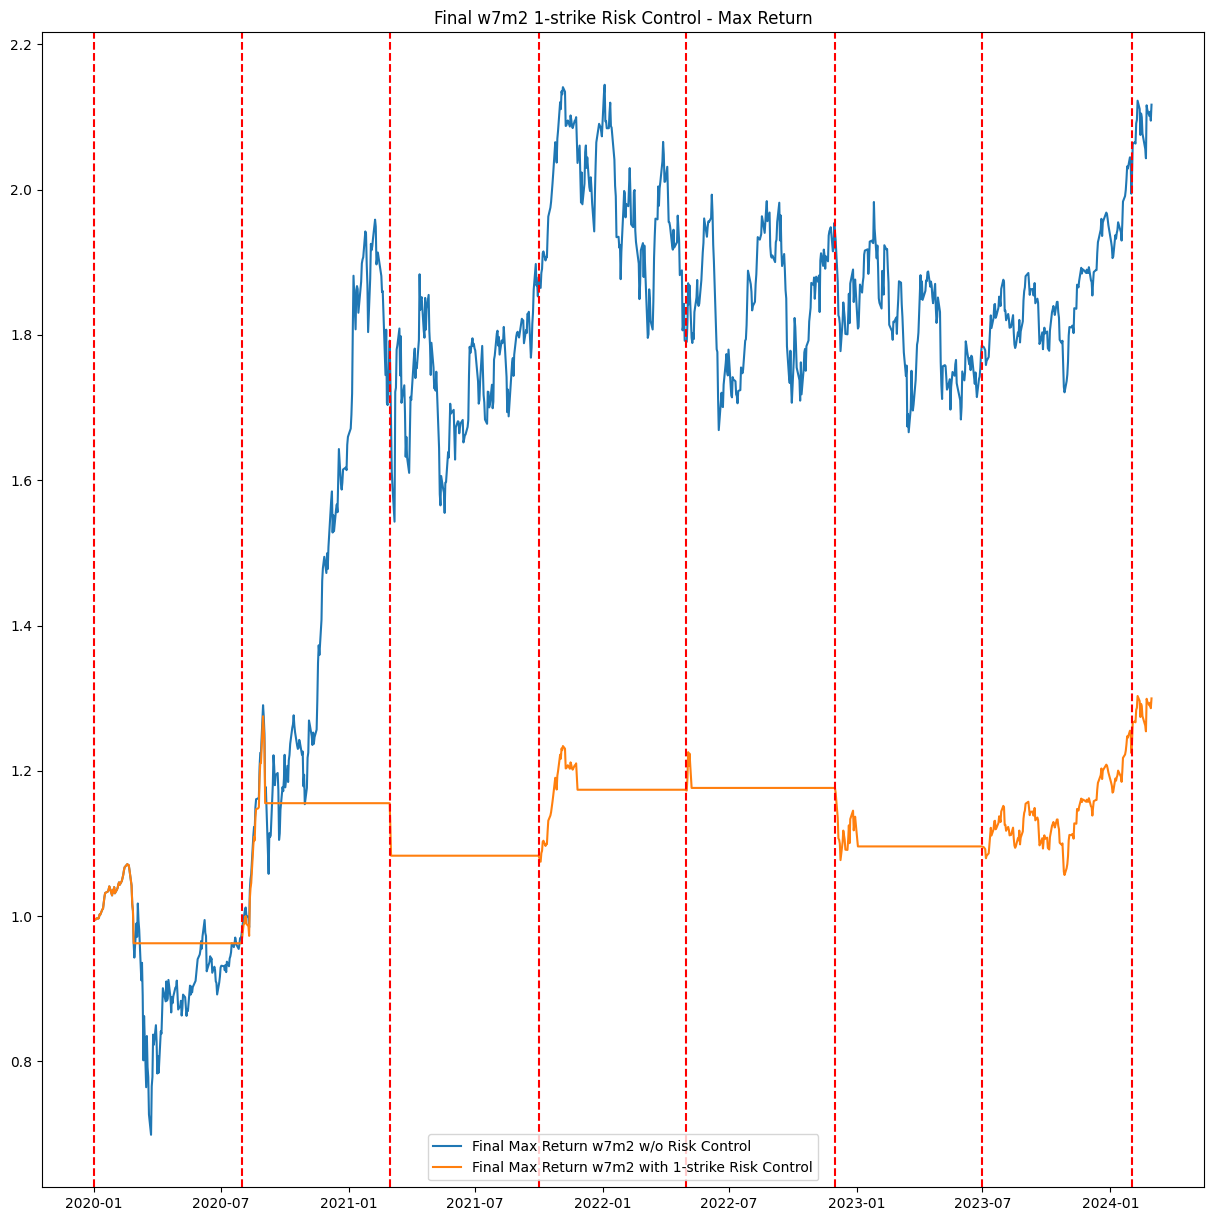

In [82]:
rm_w7m2_max =\
    risk_control(final_model[2], final_model_max_threshold, final_test_tag, 1)
rm_w7m2_max =\
    rm_w7m2_max.rename(
    columns={'ret': 'old_ret',
             'PnL': 'old_PnL',
             'pct_change': 'ret',
             'PnL_rm': 'PnL'}
    )
print(rm_w7m2_max.tail())
plt.figure(figsize=[15,15])
plt.plot(rm_w7m2_max['old_PnL'], label = 'Final Max Return w7m2 w/o Risk Control')
plt.plot(rm_w7m2_max['PnL'], label = 'Final Max Return w7m2 with 1-strike Risk Control')
plt.title('Final w7m2 1-strike Risk Control - Max Return')

for date in final_test_tag[:-1]:
    date = pd.to_datetime(date)
    plt.axvline(x=date, color='red', linestyle='--')
plt.legend()
plt.show()

           NoDur     Durbl Manuf Enrgy     HiTec Telcm     Shops     Hlth   \
2024-02-23   0.0      -0.0   0.0  -0.0 -0.002998   0.0  0.000002  0.000001   
2024-02-26  -0.0  0.000001  -0.0   0.0 -0.003997  -0.0  0.000001      -0.0   
2024-02-27  -0.0       0.0   0.0  -0.0  0.002798   0.0  0.000001       0.0   
2024-02-28  -0.0       0.0   0.0  -0.0 -0.005795   0.0       0.0 -0.000001   
2024-02-29   0.0       0.0   0.0   0.0  0.010491   0.0  0.000002 -0.000001   

               Utils Other   old_ret   old_PnL       ret       PnL  
2024-02-23       0.0   0.0 -0.002995  2.109735 -0.002995  2.109735  
2024-02-26 -0.000001  -0.0 -0.003997  2.101302 -0.003997  2.101302  
2024-02-27  0.000001   0.0    0.0028  2.107186  0.002800  2.107186  
2024-02-28       0.0  -0.0 -0.005795  2.094974 -0.005795  2.094974  
2024-02-29       0.0   0.0  0.010494  2.116958  0.010494  2.116958  


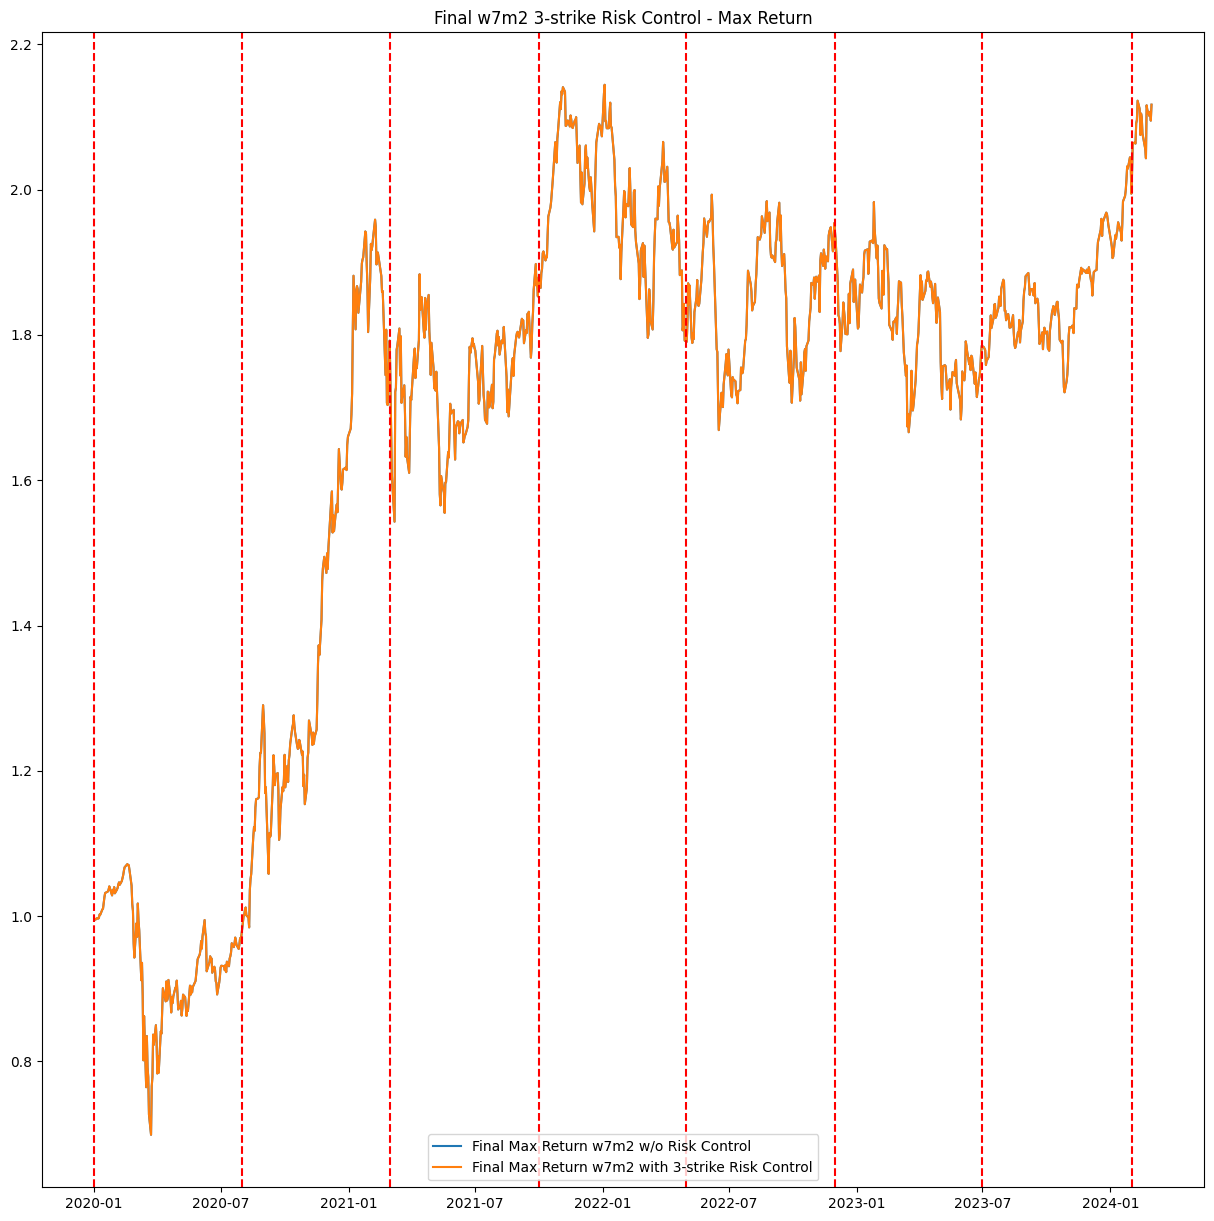

In [83]:
rm_w7m2_max =\
    risk_control(final_model[2], final_model_max_threshold, final_test_tag, 3)
rm_w7m2_max =\
    rm_w7m2_max.rename(
    columns={'ret': 'old_ret',
             'PnL': 'old_PnL',
             'pct_change': 'ret',
             'PnL_rm': 'PnL'}
    )
print(rm_w7m2_max.tail())
plt.figure(figsize=[15,15])
plt.plot(rm_w7m2_max['old_PnL'], label = 'Final Max Return w7m2 w/o Risk Control')
plt.plot(rm_w7m2_max['PnL'], label = 'Final Max Return w7m2 with 3-strike Risk Control')
plt.title('Final w7m2 3-strike Risk Control - Max Return')

for date in final_test_tag[:-1]:
    date = pd.to_datetime(date)
    plt.axvline(x=date, color='red', linestyle='--')
plt.legend()
plt.show()

<span style="color:red;">* Setting VaR violation threshold to 2 strikes would be proper and reasonable</span>

In [84]:
rm_w7m2_max =\
    risk_control(final_model[2], final_model_max_threshold, final_test_tag, 2)
rm_w7m2_max =\
    rm_w7m2_max.rename(
    columns={'ret': 'old_ret',
             'PnL': 'old_PnL',
             'pct_change': 'ret',
             'PnL_rm': 'PnL'}
    )
rm_w7m2_max.tail()


2nd strike:  2020-03-12 00:00:00
risk control No. 1
from 2020-03-13 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2020-03-23 00:00:00
risk control No. 2
from 2020-03-24 00:00:00 to 2020-08-01 00:00:00
2nd strike:  2021-03-04 00:00:00
risk control No. 3
from 2021-03-05 00:00:00 to 2021-10-01 00:00:00


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other,old_ret,old_PnL,ret,PnL
2024-02-23,0.0,-0.0,0.0,-0.0,-0.002998,0.0,0.000002,0.000001,0.0,0.0,-0.002995,2.109735,-0.002995,1.488743
2024-02-26,-0.0,0.000001,-0.0,0.0,-0.003997,-0.0,0.000001,-0.0,-0.000001,-0.0,-0.003997,2.101302,-0.003997,1.482793
2024-02-27,-0.0,0.0,0.0,-0.0,0.002798,0.0,0.000001,0.0,0.000001,0.0,0.0028,2.107186,0.002800,1.486945
2024-02-28,-0.0,0.0,0.0,-0.0,-0.005795,0.0,0.0,-0.000001,0.0,-0.0,-0.005795,2.094974,-0.005795,1.478327
2024-02-29,0.0,0.0,0.0,0.0,0.010491,0.0,0.000002,-0.000001,0.0,0.0,0.010494,2.116958,0.010494,1.493841


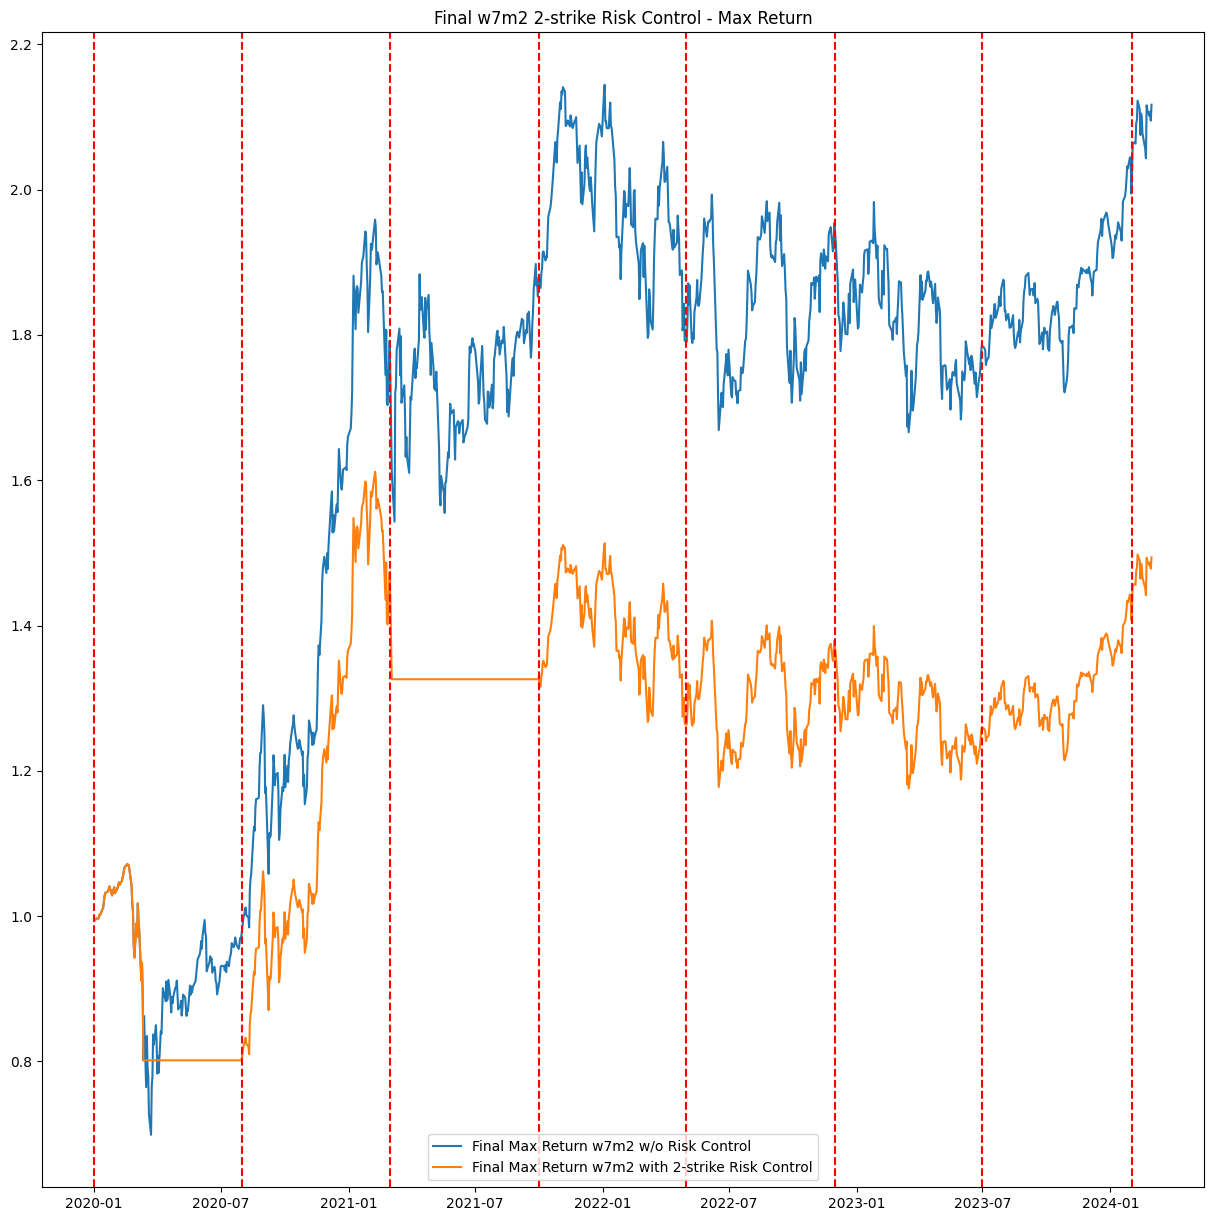

In [85]:
plt.figure(figsize=[15,15])
plt.plot(rm_w7m2_max['old_PnL'], label = 'Final Max Return w7m2 w/o Risk Control')
plt.plot(rm_w7m2_max['PnL'], label = 'Final Max Return w7m2 with 2-strike Risk Control')
plt.title('Final w7m2 2-strike Risk Control - Max Return')

for date in final_test_tag[:-1]:
    date = pd.to_datetime(date)
    plt.axvline(x=date, color='red', linestyle='--')
plt.legend()
plt.show()

In [86]:
# Consolidate Out-of-Sample Performance Metrics
final_w7m2_result =\
{

    'final w7m2 Max Return Port.':
    [

        rm_w7m2_max['PnL'][-1]**(252/len(rm_max))-1,
        rm_w7m2_max['PnL'][-1]-1,

        rm_w7m2_max['ret'].std()*252**0.5,
        VaR_para(rm_w7m2_max, 0.01),
        VaR_hist(rm_w7m2_max, 0.01),
        VaR_para(rm_w7m2_max, 0.05),
        VaR_hist(rm_w7m2_max, 0.05),
    ],
}


final_w7m2_result =\
    pd.DataFrame(final_w7m2_result)


final_w7m2_result.index =\
[

    'Ann. Return', 
    'Total Return',
  
    'Ann. Vol',     
    'VaR 1d 1% - para',
    'VaR 1d 1% - hist',
    'VaR 1d 5% - para',
    'VaR 1d 5% - hist',
]


final_w7m2_result

,final w7m2 Max Return Port.
Ann. Return,0.041018
Total Return,0.493841
Ann. Vol,0.239655
VaR 1d 1% - para,0.034622
VaR 1d 1% - hist,0.045957
VaR 1d 5% - para,0.024334
VaR 1d 5% - hist,0.023626


In [87]:
# below is before risk control for comparison
final_model = Model_Decisions[-2]
final_model[0][['Roll Max Return Port.']]

,Roll Max Return Port.
Ann. Return,0.197829
Total Return,1.116958
Ann. Vol,0.303912
VaR 1d 1% - para,0.043637
VaR 1d 1% - hist,0.051281
VaR 1d 5% - para,0.030590
VaR 1d 5% - hist,0.027416
